In [1]:
import os
import glob
import json
import pymworks
import re
import datautils
import copy
import math
import time

import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as pl
import cPickle as pkl
from cPickle import PicklingError

import scipy.stats as spstats

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')
/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/datautils/__init__.py:22: UserWarning: datautils.mongo failed to import with: No module named pymongo
  warnings.warn('datautils.mongo failed to import with: %s' % E)


In [2]:
%matplotlib notebook

# Parse .mwk data files

In [3]:
import utils as util
import process_datafiles as processd

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]


utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 49

In [4]:
import utils as util
import process_datafiles as processd

## 1. Set sources and output dirs:

In [5]:
# Set path params:
root = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

# Set all output dirs
cohort_dirs = [os.path.split(p)[0] for p in glob.glob(os.path.join(root, paradigm, 'cohort_data', 'A*', 'raw'))]
cohort_list = [re.search('(\D{2})', os.path.split(pf)[-1]).group(0) for pf in cohort_dirs]

for cohort in cohort_list:
    working_dir = os.path.join(root, paradigm, 'cohort_data', cohort)   
    output_dir = os.path.join(working_dir, 'processed')
    output_figdir = os.path.join(output_dir, 'figures')
    output_datadir = os.path.join(output_dir, 'data')
    if not os.path.exists(output_figdir): os.makedirs(output_figdir)
    if not os.path.exists(output_datadir): os.makedirs(output_datadir)

# Set experiment parsing vars and params:
response_types = ['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
outcome_types = outcome_types = ['success', 'ignore', 'failure']
ignore_flags = None


## 2. Get session info for all animals

In [41]:
reload(util)

utils.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 49

<module 'utils' from 'utils.py'>

In [42]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

metadata = util.get_metadata(paradigm, rootdir=rootdir, create_meta=True)


Loading existing metadata...
Creating new metadata...


In [43]:
metadata['suffix'].unique()

array(['', 'b', 'big', 'stimB', 'stimBlowerbound', 'stimClowerbound',
       'stimBupperbound', 'stimCupperbound', 'small', 'stimC', 'c',
       'stimCalwaysReward', 'alwaysReward', 'size', 'adeptrotl',
       'bdeptrotr', 'deptrotl', 'adeptrotr', 'asize', 'bdeptrotl',
       'background', 'deptrotr', 'balwaysReward', 'initial', 'deprotl',
       'backgroundalwaysReward', 'bsize', 'morphs', 'aalwaysReward',
       'empty', 'aasize', 'a', 'probeNewObjects', 'occluded', 'r', 'd',
       'transparency', 'nominrt'], dtype=object)

In [44]:
# animalid = 'AM1'
# session = 20180404

animalid = 'AJ1'
session = 20160622 # 160622b.mwk

# eeport/cohort_data/AM/raw/AM1_171110bdeptrotl.mwk

In [45]:
session_meta = metadata[(metadata['animalid']==animalid) & (metadata['session']==session)]
S = util.Session(session_meta)
print(S.source)




['/n/coxfs01/behavior-data/threeport/cohort_data/AJ/raw/AJ1_160622a.mwk', '/n/coxfs01/behavior-data/threeport/cohort_data/AJ/raw/AJ1_160622b.mwk']


In [ ]:
S.get_trials()

***** Parsing trials *****
-- saving tmp outfile to: /n/coxfs01/behavior-data/threeport/cohort_data/AJ/processed/tmp_files/AJ1_160622a.pkl
-- finding stop


In [9]:
dfn = S.source[1]
df = pymworks.open(dfn)

In [11]:
#util.get_screen_info(df, run_bounds = S.flags['run_bounds'])

TypeError: 'NoneType' object has no attribute '__getitem__'

In [14]:
trials, flags, df = util.parse_trials(dfn)

***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagShowStimRight
More than 1 value found for flag: FlagShowStimLeft
(95, 101)
N total response events:  69
N total outcome events:  69
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AJ/raw/AJ1_160622b.mwk
N valid trials: 69


In [15]:
flags

{'FlagAddFreeRewardToEarnedReward': [1],
 'FlagAlwaysEnforceMaxSeqLeng': [1],
 'FlagAlwaysReward': [0],
 'FlagAutomaticBiasSuppression': [1],
 'FlagCorrectionTrials': [0],
 'FlagCueStimSound': [0],
 'FlagDiscardHalfOfTheTrials': [1],
 'FlagEnrichSomeStaircases': [0],
 'FlagForceCueStimSoundOff': [0],
 'FlagLongPunishment': [1],
 'FlagPlayOutcomeSound': [1],
 'FlagRepeatedTrial': [0],
 'FlagSampUniformDistr': [0],
 'FlagShowOnlyTrainedAxes': [0],
 'FlagShowStimAfterResponse': [1],
 'FlagShowStimLeft': [1],
 'FlagShowStimRight': [0],
 'FlagShowVisualStimuli': [1],
 'FlagStaircaseDeptRotLeft': [1],
 'FlagStaircaseDeptRotRight': [0],
 'FlagStaircaseHorizSeparation': [0],
 'FlagStaircasePosHL': [0],
 'FlagStaircasePosHR': [0],
 'FlagStaircasePosVD': [0],
 'FlagStaircasePosVU': [0],
 'FlagStaircaseProbFreeRew': [0],
 'FlagStaircaseRotACW': [0],
 'FlagStaircaseRotCW': [0],
 'FlagStaircaseSize': [0],
 'run_bounds': [(5827366921, 9853552655)]}

In [16]:
util.get_screen_info(df, run_bounds=flags['run_bounds'])

{'distance': 12.5,
 'height': 11.75,
 'refresh_rate_hz': 60.0,
 'units': 'inches',
 'width': 14.75}

In [9]:
S.get_trials()
# with open(S.source[0], 'rb') as f:
#     S = pkl.load(f)
    

***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagForceCueStimSoundOff
(686, 690)
N total response events:  680
N total outcome events:  680
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG7_150616.mwk
N valid trials: 680


[{'action': 'draw',
  'depth_rotation': 30,
  'duration': 5448208,
  'file_hash': '2273009ec0198febf189d960122814da1b28c91a',
  'filename': '/var/folders/qt/hrqmn51n4qz70sz1xwphms200000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N1_CamRot_y30.png',
  'name': 'Blob_N1_CamRot_y30',
  'no_feedback': False,
  'outcome': 'success',
  'outcome_time': 326120546266,
  'pos_x': 0.0,
  'pos_y': 0.0,
  'response': 'Announce_AcquirePort3',
  'response_time': 326120545898,
  'rotation': 0.0,
  'size': 30.0,
  'size_x': 52.40999984741211,
  'size_y': 52.40999984741211,
  'time': 326119690002,
  'type': 'image'},
 {'action': 'draw',
  'depth_rotation': 30,
  'duration': 5148310,
  'file_hash': '753b7a43ec962eac9db7b591728076e42bcdcd51',
  'filename': '/var/folders/qt/hrqmn51n4qz70sz1xwphms200000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs

In [10]:
S.get_summary()

... Getting session summary ...
... Getting stimulus counts ...


In [11]:
dst_dir = os.path.join(S.source[0].split('/raw')[0], 'processed')
dst_dir_figures = os.path.join(dst_dir, 'figures')
dst_dir_figures

tmp_file_dir = os.path.join(dst_dir_figures, 'tmp_files')

tmp_processed_file = os.path.join(tmp_file_dir, 'proc_%s_%s.pkl' % (S.animalid, S.session))
tmp_processed_file

'/n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/figures'

In [22]:
with open(tmp_processed_file, 'wb') as f:
    pkl.dump(S, f, protocol=pkl.HIGHEST_PROTOCOL)

In [17]:
dfn = S.source[0]
print(dfn)

/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG7_150616.mwk


In [18]:
df = pymworks.open(dfn)

In [19]:
df.get_events('FlagStaircaseRotACW')

[Event[code=95, name=FlagStaircaseRotACW, time=326035857827, value=0.0],
 Event[code=95, name=FlagStaircaseRotACW, time=326036113174, value=0.0]]

In [29]:
326051730952 - 326036113174

15617778

In [25]:
S.flags['run_bounds']

(326051730952, 334314116599)

In [20]:
(334314116599-326051730952)/1E6

8262.385647

In [23]:
df.get_events('#state_system_mode')

[Event[code=5, name=#state_system_mode, time=326035857729, value=0],
 Event[code=5, name=#state_system_mode, time=326036113081, value=0],
 Event[code=5, name=#state_system_mode, time=326051730952, value=2],
 Event[code=5, name=#state_system_mode, time=334314116599, value=1],
 Event[code=5, name=#state_system_mode, time=334314116942, value=0]]

In [26]:
df.get_codec()

{0: '#codec',
 1: '#systemEvent',
 2: '#components',
 3: '#termination',
 4: '#allowAltFailover',
 5: '#state_system_mode',
 6: '#announceMessage',
 7: '#stimDisplayUpdate',
 8: '#beamPosition',
 9: '#experimentLoadProgress',
 10: '#announceStimulus',
 11: '#announceSound',
 12: '#announceCalibrator',
 13: '#requestCalibrator',
 14: '#announceCurrentState',
 15: '#annouceTrial',
 16: '#announceBlock',
 17: '#announceAssertion',
 18: '#serverName',
 19: '#mainScreenInfo',
 20: '#warnOnSkippedRefresh',
 21: 'debuggerActive',
 22: 'debuggerRunning',
 23: 'debuggerStep',
 24: '#serialBridgeAddress',
 25: '#syringePumpPort',
 26: 'Adjusted_Metric_Correct_Strategy',
 27: 'GainFactorCorrectMetric',
 28: 'FlagAutomaticBiasSuppression',
 29: 'WatchResponseSide',
 30: 'WatchSuccessBias',
 31: 'Metric_Correct_Strategy',
 32: 'Metric_Biased_Strategy',
 33: 'Metric_Alternation_Strategy',
 34: 'FlagStaircaseHorizSeparation',
 35: 'WatchSuccessStair_HorizSep',
 36: 'HorizSep_stair_up_criterion',
 37:

In [31]:
import pymworks

In [56]:
run_bounds = S.flags['run_bounds']
screenkeys = ['distance', 'width', 'height', 'units', 'refresh_rate_hz']
mainscreen_evs = sorted([e for e in df.get_events('#mainScreenInfo') \
               if run_bounds[0] <= e.time <= run_bounds[1]], key=lambda x: x.time)
if len(mainscreen_evs) == 0:
    # Find last event
    mainscreen_evs = sorted(df.get_events('#mainScreenInfo'), key=lambda x: x.time)

mainscreen_ev = mainscreen_evs[-1]
screen = dict((k, mainscreen_ev.value[k]) for k in screenkeys)
screen

{'distance': 12.5,
 'height': 11.75,
 'refresh_rate_hz': 60.0,
 'units': 'inches',
 'width': 14.75}

In [65]:
rb = util.get_run_time(df)

print(rb)

-- finding stop
[(326051730952, 334314116599)]


In [64]:
df.get_maximum_time()

334340112659

In [ ]:
[Event[code=5, name=#state_system_mode, time=326035857729, value=0],
 Event[code=5, name=#state_system_mode, time=326036113081, value=0],
 Event[code=5, name=#state_system_mode, time=326051730952, value=2],
 Event[code=5, name=#state_system_mode, time=334314116599, value=1],
 Event[code=5, name=#state_system_mode, time=334314116942, value=0]]

In [60]:
round(e.time/1E3)


326036113.0

In [53]:
[round(r/1E3) for r in run_bounds]


[326051731.0, 334314117.0]

In [55]:
(326051731.0 - 326036113) / 1E3


15.618

In [38]:
df.get_events('#mainScreenInfo')

[Event[code=19, name=#mainScreenInfo, time=326035857746, value={'distance': 12.5, 'always_display_mirror_window': 0, 'announce_individual_stimuli': 1, 'display_to_use': 0, 'height': 11.75, 'width': 14.75, 'redraw_on_every_refresh': 1, 'units': 'inches', 'refresh_rate_hz': 60.0, 'mirror_window_base_height': 400}],
 Event[code=19, name=#mainScreenInfo, time=326036113097, value={'distance': 12.5, 'always_display_mirror_window': 0, 'announce_individual_stimuli': 1, 'display_to_use': 0, 'height': 11.75, 'width': 14.75, 'redraw_on_every_refresh': 1, 'units': 'inches', 'refresh_rate_hz': 60.0, 'mirror_window_base_height': 400}]]

In [40]:
screen

{'distance': 12.5,
 'height': 11.75,
 'refresh_rate_hz': 60.0,
 'units': 'inches',
 'width': 14.75}

In [15]:

training_flag_names = ['FlagAlwaysReward', #
                       'FlagStaircaseSize',
                       'FlagStaircaseDeptRotLeft', #
                       'FlagStaircaseDeptRotRight', 
                       'FlagShowOnlyTrainedAxes']

#### Get animal data (all sessions)

for key, val in S.flags.items():
    if isinstance(val, list) and len(val)==1:
        S.flags[key] = val[0]
    if key=='run_bounds' and isinstance(val[0], list): # conver back to tuple
        S.flags[key] = [tval[0] for tval in val]



In [16]:
S.flags

{'FlagAddFreeRewardToEarnedReward': array([], dtype=float64),
 'FlagAlwaysEnforceMaxSeqLeng': array([], dtype=float64),
 'FlagAlwaysReward': array([], dtype=float64),
 'FlagAutomaticBiasSuppression': array([], dtype=float64),
 'FlagCorrectionTrials': array([], dtype=float64),
 'FlagCueStimSound': array([], dtype=float64),
 'FlagDiscardHalfOfTheTrials': array([], dtype=float64),
 'FlagEnrichSomeStaircases': array([], dtype=float64),
 'FlagForceCueStimSoundOff': 0,
 'FlagLongPunishment': array([], dtype=float64),
 'FlagPlayOutcomeSound': array([], dtype=float64),
 'FlagRepeatedTrial': array([], dtype=float64),
 'FlagSampUniformDistr': array([], dtype=float64),
 'FlagShowOnlyTrainedAxes': array([], dtype=float64),
 'FlagShowStimAfterResponse': array([], dtype=float64),
 'FlagShowStimLeft': array([], dtype=float64),
 'FlagShowStimRight': array([], dtype=float64),
 'FlagShowVisualStimuli': array([], dtype=float64),
 'FlagStaircaseDeptRotLeft': array([], dtype=float64),
 'FlagStaircaseDeptRo

In [24]:
session = 20150513

In [44]:
#### Assign flag state to each trial
multi_phase = []
diff_flag_states = {}

curr_flag_states = dict((k, v) for k, v in S.flags.items() if k in training_flag_names)


In [45]:

rm_these_bounds= []
diff_flag_lookup = {}
same_flag_lookup = {} 
for flag_name, flag_value in curr_flag_states.items():

    if hasattr(flag_value, "__len__"):
        if flag_name not in diff_flag_lookup.keys():
            diff_flag_lookup[flag_name] = dict()

        # Make sure these correspond to different run bounds
        assert len(flag_value) == len(S.flags['run_bounds']), "[%s] %s: %s -- only %i run bounds found." % (session, flag_name, str(flag_value), len(S.flags['run_bounds']))
        if session not in multi_phase:
            multi_phase.append(session)

        # Only update trials for flag names w/ differing values in session
        for rbounds, currval in zip(S.flags['run_bounds'], flag_value):
            tmp_trial_ixs = [ti for ti, trial in enumerate(S.trials) if rbounds[0] < trial['time'] < rbounds[1]]
            print(session, flag_name, currval, len(tmp_trial_ixs))
            if len(tmp_trial_ixs) > 0:
                diff_flag_lookup[flag_name][currval] = np.array(tmp_trial_ixs)
            else:
                rm_these_bounds.append(rbounds) # (rbounds, (flag_name, currval)))
    else:
        # Save non-changing flag names and values
        same_flag_lookup.update({flag_name: flag_value})

diff_flag_states[session] = diff_flag_lookup

(20150513, 'FlagAlwaysReward', 1, 487)
(20150513, 'FlagAlwaysReward', 1, 53)
(20150513, 'FlagStaircaseDeptRotLeft', 1, 487)
(20150513, 'FlagStaircaseDeptRotLeft', 1, 53)
(20150513, 'FlagStaircaseDeptRotRight', 0, 487)
(20150513, 'FlagStaircaseDeptRotRight', 0, 53)
(20150513, 'FlagShowOnlyTrainedAxes', 1, 487)
(20150513, 'FlagShowOnlyTrainedAxes', 1, 53)
(20150513, 'FlagStaircaseSize', 0, 487)
(20150513, 'FlagStaircaseSize', 0, 53)


In [28]:
multi_phase

[]

In [ ]:


        # Update same-flag states only
        for trial in sessionobj.trials:
            for flag_name, flag_value in same_flag_lookup.items():
                trial.update({flag_name: flag_value})

            # While we're here, get rid of fields we don't want for dataframe
            for ikey in ignore_keys:
                trial.pop(ikey)

        # Remove bounds if needed:
        if len(rm_these_bounds) > 0:
            print("%s, removing %i bounds" % (session, len(rm_these_bounds)))
            real_bounds = [r for r in A.flags['run_bounds'] if r not in rm_these_bounds]
            A.flags['run_bounds'] = real_bounds

    # Update sessions with trials in different phases
    for session in multi_phase:
        print('[%s] -- updating multi-phase trials' % session)
        sessionobj = A.sessions[session]    
        for flag_name, flag_values_dict in diff_flag_states[session].items():
            #print(flag_name)
            for curr_flagval, trial_ixs in flag_values_dict.items():
                for ti in trial_ixs:
                    sessionobj.trials[ti].update({flag_name: curr_flagval})

#### 3.  Process new datafiles for each animal in cohort

In [11]:
# AG2:  
# up thru 20150313 - Blob_1_RotDept_0
# starting 20150314 -- Blob_1_CamRot_y0
# morphs start 20160623

#curr_dfns = A.get_datafiles(metadf)
#curr_dfns = [dfn for dfn in raw_fns if re.search('%s(\d+)' % cohort, dfn).group(0)==A.animalid]


In [8]:
animalid = 'AG2'

# Get current animal session info:
A = pb.Animal(animalid=animalid, experiment=paradigm) #, output_datadir=output_datadir)
curr_processed_dir = os.path.join(root, paradigm, 'cohort_data', cohort, 'processed')

# --- Create or load animal datafile:
animal_datafile = os.path.join(curr_processed_dir, 'data', '%s.pkl' % animalid)

# --- Check if processed file exists -- load or create new.
create_new = False
if os.path.exists(animal_datafile):
    try:
        with open(animal_datafile, 'rb') as f:
            animal = pkl.load(f)   
    except EOFError:
        create_new = True

# --- Process new datafiles / sessions:
all_sessions = metadata[metadata.animalid==animalid]['session'].values
old_sessions = [skey for skey, sobject in A.sessions.items() if sobject is not None]
print("[%s]: Found %i processed sessions." % (animalid, len(old_sessions)))
new_sessions = [s for s in all_sessions if s not in old_sessions]

print("[%s]: There are %i out of %i found session datafiles to process." % (A.animalid, len(new_sessions), len(all_sessions)))


[AG2]: Found 0 processed sessions.
[AG2]: There are 196 out of 196 found session datafiles to process.


#### Try w/ 1 session first

In [9]:
reload(pb)

<module 'parse_behavior' from 'parse_behavior.pyc'>

In [203]:
animalid='AL10' #AL1_170802
session = 20170822 #AL1_170728.mwk  AG1_161027d AL10_170822b
sorted(metadata[(metadata.animalid==animalid) & (metadata.session==session)]['datasource'], key=natural_keys)


['/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk',
 '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk']

In [204]:
session_meta = metadata[(metadata.animalid==animalid) & (metadata.session==session)]

S = util.Session(session_meta)
S.print_meta()


Name: AL10
Session: 20170822
('Source: ', ['/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk', '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk'])


In [205]:
dst_dir=None
create_new= False
# Create output dir for processed data
src_dir = S.source[0] if isinstance(S.source, list) else S.source

if dst_dir is None or dst_dir == '/tmp':
    dst_dir = os.path.join(S.source[0].split('/raw')[0], 'processed')
    dst_dir_figures = os.path.join(dst_dir, 'figures')
    if not os.path.exists(dst_dir_figures):
        os.makedirs(dst_dir_figures)
#print("Saving processed output to: %s" % dst_dir)

# Check if session data exists
tmp_file_dir = os.path.join(dst_dir_figures, 'tmp_files')
if not os.path.exists(tmp_file_dir): os.makedirs(tmp_file_dir)
tmp_processed_file = os.path.join(tmp_file_dir, 'proc_%s_%s.pkl' % (S.animalid, S.session))
parse_data=False
if os.path.exists(tmp_processed_file) and (create_new is False):
    print("... loading existing parsed session file")
    try:
        with open(tmp_processed_file, 'rb') as f:
            S = pkl.load(f)
    except ImportError:
        parse_data=True
else:
    parse_data = True
print(parse_data)

... loading existing parsed session file
False


In [206]:
dfn = session_meta['datasource'].values[-1]
print(dfn)
stim_blacklists = [
    lambda s: (('type' in s.keys()) and (s['type'] == 'blankscreen')),
    ]

print "***** Parsing trials *****"
df = pymworks.open(dfn)


/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk
***** Parsing trials *****


In [207]:
dfn

'/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822.mwk'

In [208]:
df.get_events(['FlagAlwaysReward'])

[Event[code=203, name=FlagAlwaysReward, time=1210450809715, value=0],
 Event[code=203, name=FlagAlwaysReward, time=1210451065223, value=0],
 Event[code=203, name=FlagAlwaysReward, time=1211356793750, value=0]]

In [98]:
df.get_codec()

{0: '#codec',
 1: '#systemEvent',
 2: '#components',
 3: '#termination',
 4: '#allowAltFailover',
 5: '#state_system_mode',
 6: '#announceMessage',
 7: '#stimDisplayUpdate',
 8: '#beamPosition',
 9: '#experimentLoadProgress',
 10: '#announceStimulus',
 11: '#announceSound',
 12: '#announceCalibrator',
 13: '#requestCalibrator',
 14: '#announceCurrentState',
 15: '#annouceTrial',
 16: '#announceBlock',
 17: '#announceAssertion',
 18: '#serverName',
 19: '#mainScreenInfo',
 20: '#warnOnSkippedRefresh',
 21: 'debuggerActive',
 22: 'debuggerRunning',
 23: 'debuggerStep',
 24: '#serialBridgeAddress',
 25: '#syringePumpPort',
 26: 'Adjusted_Metric_Correct_Strategy',
 27: 'GainFactorCorrectMetric',
 28: 'FlagAutomaticBiasSuppression',
 29: 'WatchResponseSide',
 30: 'WatchSuccessBias',
 31: 'Metric_Correct_Strategy',
 32: 'Metric_Biased_Strategy',
 33: 'Metric_Alternation_Strategy',
 34: 'FlagStaircaseHorizSeparation',
 35: 'WatchSuccessStair_HorizSep',
 36: 'HorizSep_stair_up_criterion',
 37:

In [233]:
#dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL1_170817.mwk'
#dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk' #AL10_170822b

#dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL1_170911.mwk' #AL10_170822b
dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL2_170812.mwk' #AL10_170822b

#20170911

#20150422
df = pymworks.open(dfn)
bounds = util.get_run_time(df)

-- finding stop
-- finding stop


In [234]:
bounds


[(1098905462, 1105295741), (1112817098, 9790000377)]

In [235]:
ignore_flags = None

In [236]:
df.get_events(['FlagAlwaysReward'])

[Event[code=203, name=FlagAlwaysReward, time=243112794, value=0.0],
 Event[code=203, name=FlagAlwaysReward, time=243396580, value=0.0],
 Event[code=203, name=FlagAlwaysReward, time=1098905830, value=0.0],
 Event[code=203, name=FlagAlwaysReward, time=1112817582, value=0.0]]

In [237]:
df.get_events(['FlagStaircaseSize'])

[Event[code=89, name=FlagStaircaseSize, time=243112701, value=-1],
 Event[code=89, name=FlagStaircaseSize, time=243396401, value=-1],
 Event[code=89, name=FlagStaircaseSize, time=483997169, value=0.0],
 Event[code=89, name=FlagStaircaseSize, time=1098905675, value=0.0],
 Event[code=89, name=FlagStaircaseSize, time=1112817373, value=0.0]]

In [238]:
df.get_events(['FlagShowOnlyTrainedAxes'])

[Event[code=59, name=FlagShowOnlyTrainedAxes, time=243112672, value=1],
 Event[code=59, name=FlagShowOnlyTrainedAxes, time=243396325, value=1],
 Event[code=59, name=FlagShowOnlyTrainedAxes, time=1098905626, value=1],
 Event[code=59, name=FlagShowOnlyTrainedAxes, time=1112817304, value=1]]

In [239]:
df.get_events(['FlagStaircaseDeptRotLeft'])

[Event[code=97, name=FlagStaircaseDeptRotLeft, time=243112707, value=-1],
 Event[code=97, name=FlagStaircaseDeptRotLeft, time=243396414, value=-1],
 Event[code=97, name=FlagStaircaseDeptRotLeft, time=488096617, value=0.0],
 Event[code=97, name=FlagStaircaseDeptRotLeft, time=1098905686, value=0.0],
 Event[code=97, name=FlagStaircaseDeptRotLeft, time=1112817389, value=0.0]]

In [240]:
df.get_events(['FlagStaircaseDeptRotRight'])

[Event[code=96, name=FlagStaircaseDeptRotRight, time=243112706, value=1],
 Event[code=96, name=FlagStaircaseDeptRotRight, time=243396413, value=1],
 Event[code=96, name=FlagStaircaseDeptRotRight, time=1098905685, value=1],
 Event[code=96, name=FlagStaircaseDeptRotRight, time=1112817388, value=1]]

In [248]:
[round(r/1e6, 3) for r in np.diff([e.time-243112707 for e in df.get_events(['FlagStaircaseDeptRotLeft'])])]



[0.284, 244.7, 610.809, 13.912]

In [116]:
all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
ignore_flags_with_name = ['Curr', 'current', 'Current', 'curr']
ignore_flags = [f for f in all_flags if any([fstr in f for fstr in ignore_flags_with_name])]
flag_names = [f for f in all_flags if f not in ignore_flags]

In [117]:
ignore_flags

['FlagNoFeedbackInCurrentTrial',
 'FlagDiscardTrialWithCurrentDeptRot',
 'Flag_MatchCurrStairTrial',
 'FlagDiscardCurrStim']

In [118]:
flag_names

['FlagAutomaticBiasSuppression',
 'FlagStaircaseHorizSeparation',
 'FlagStaircaseProbFreeRew',
 'FlagEnrichSomeStaircases',
 'FlagForceCueStimSoundOff',
 'FlagShowOnlyTrainedAxes',
 'FlagDiscardHalfOfTheTrials',
 'FlagSampUniformDistr',
 'FlagStaircaseSize',
 'FlagStaircasePosHR',
 'FlagStaircasePosHL',
 'FlagStaircasePosVU',
 'FlagStaircasePosVD',
 'FlagStaircaseRotCW',
 'FlagStaircaseRotACW',
 'FlagStaircaseDeptRotRight',
 'FlagStaircaseDeptRotLeft',
 'FlagPlayOutcomeSound',
 'FlagLongPunishment',
 'FlagCorrectionTrials',
 'FlagRepeatedTrial',
 'FlagAlwaysReward',
 'FlagAddFreeRewardToEarnedReward',
 'FlagAlwaysEnforceMaxSeqLeng',
 'FlagShowVisualStimuli',
 'FlagCueStimSound',
 'FlagShowStimRight',
 'FlagShowStimLeft',
 'FlagShowStimAfterResponse']

In [60]:
codec = df.get_codec()
all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]


In [135]:

# Get run bounds:
bounds = util.get_run_time(df)


-- finding stop
-- finding stop


In [136]:
(bounds[0][1] - bounds[0][0]) / 1E6

83.991186

In [199]:
ignore_flags = []
remove_unknown = True

trials = []; flag_list = []; flags = {};
for bound in bounds:

    if (bound[1]-bound[0])/1E6 < 2.0:
        continue

    # Identify no feedback conditions
    #  231: 'nofeedback_depth_rotation_min',
    #  232: 'nofeedback_depth_rotation_max',
    #  233: 'nofeedback_size_min',
    #  234: 'nofeedback_size_max',
    if 'nofeedback_depth_rotation_min' not in df.get_codec().values():
        always_feedback = True
    else:
        always_feedback = False
        no_fb_params_tmp = df.get_events(['nofeedback_size_min',
                                       'nofeedback_size_max',
                                       'nofeedback_depth_rotation_min',
                                       'nofeedback_depth_rotation_max'])
        fb_info = list(set([(e.name, e.value) for e in no_fb_params_tmp]))
        no_fb = {}
        for fb in fb_info:
            param = '_'.join(fb[0].split('_')[1:-1])
            if param not in no_fb.keys():
                no_fb[param] = [fb[1]]
            else:
                no_fb[param].append(fb[1])

    # Get display events:
    tmp_devs = df.get_events('#stimDisplayUpdate')                     
    tmp_devs = [i for i in tmp_devs if bound[0] <= i['time']<= bound[1]] 

    # Get behavior flags:
    codec = df.get_codec()
    all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
    ignore_flags_with_name = ['Curr', 'current', 'Current', 'curr']
    ignore_flags = [f for f in all_flags if any([fstr in f for fstr in ignore_flags_with_name])]
    flag_names = [f for f in all_flags if f not in ignore_flags]
    tmp_flags = dict((flag, None) for flag in flag_names)
    for flag in flag_names:
        if flag == 'FlagNoFeedbackInCurrentTrial': continue
        found_values = np.unique([e.value for e in df.get_events(flag) if bound[0] <= e.time <=bound[1]])
        if (len(found_values) > 1) > 1: #or (len(list(set(found_values)))) > 1:
            print("More than 1 value found for flag: %s" % flag)
            # Take last value
            last_found_val = [e.value for e in sorted(df.get_events(flag), key=lambda x: x.time)][-1]
            tmp_flags[flag] = int(last_found_val)
        elif (len(found_values) == 1): # or (len(list(set(found_values)))) == 1:
            tmp_flags[flag] = int(found_values[0])
        else:
            tmp_flags[flag] = found_values
        #    tmp_flags.pop(flag)

#         # Add current flag values to flags list:
#         flag_list.append(tmp_flags)

#         # Add boundary time to flag info:
#         tmp_flags.update({'run_bounds': bound})

    # Check for valid response types and get all response events:
    response_types = [r for r in response_types if r in codec.values()]
    response_evs = [e for e in df.get_events(response_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value==1]    
    outcome_evs = [e for e in df.get_events(outcome_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value is not None and e.value != 0] #not in [0, None]]  
    print(len(response_evs), len(outcome_evs))

    # Sync response events to true outcome events:  response occurs after stimulus, stimulus is the master
    # Convert to trials: match stimulus events and response events:
    outcome_key = 'response'
    responses = util.to_trials(tmp_devs, response_evs, outcome_key=outcome_key,
                                               duration_multiplier=1.,
                                               stim_blacklists=stim_blacklists,
                                               remove_unknown=True)

    # **sync outcome events to response events as master (direction 1=slave after master, -1=slave before master)
    #outcome_evs = [e for e in df.get_events(outcome_types) if (bound[0] < e['time'] < bound[1]) and e.value!=0]
    outcomes = pymworks.events.utils.sync(outcome_evs, responses, direction=1, mkey=lambda x: x['response_time'])

    print "N total response events: ", len(responses)
    print "N total outcome events: ", len(outcomes)

    assert len(responses) == len(outcomes), "**ERROR:  N responses (%i) != N outcomes (%i)" % (len(responses), len(outcomes))
    tmp_trials = copy.copy(responses)
    for trial_ix, (response, outcome) in enumerate(zip(responses, outcomes)):
        if outcome is not None:
            tmp_trials[trial_ix].update({'outcome': outcome.name, 'outcome_time': outcome.time}) #['outcome']})
        else:
            tmp_trials[trial_ix].update({'outcome': 'unknown'})

    # Get rid of display events without known outcome within 'duration_multiplier' time
    if remove_orphans:                                                  
        orphans = [(i,x) for i,x in enumerate(tmp_trials) if\
                    x['outcome']=='unknown' or x['%s' % outcome_key]=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['outcome']=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['%s' % outcome_key]=='unknown']

        print "Found and removed %i orphan stimulus events in file %s" % (len(orphans), df.filename)
        print "N valid trials: %i" % len(tmp_trials)

    # Add current trials in chunk to trials list:
    trials.extend(tmp_trials)

if len(tmp_trials) > 0:
    # Add current flag values to flags list:
    flag_list.append(tmp_flags)

    # Add boundary time to flag info:
    tmp_flags.update({'run_bounds': bound})


(144, 150)
N total response events:  138
N total outcome events:  138
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk
N valid trials: 138


In [200]:

for t in trials:
    stim_aspect = [v.value for v in df.get_events('StimAspectRatio')][-1]
    assert t['response_time'] < t['outcome_time'], "**ERROR: Mismatch in response/outcome alignment"

    # Supplement trial info
    stimname = t['name'].split(' ')[0].split('.png')[0]
    t['name'] = stimname
    # Can be: Blob_1_RotDep_0, Blob_N2_CamRot_y-45

    if 'RotDep' in stimname:
        drot_str = stimname.split('_')[-1]
        depthrot_value = int(drot_str)
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
    elif 'CamRot' in stimname and 'LighPos' in stimname:
        depthrot_value = int(stimname.split('CamRot_y')[1].split('_')[0])
        lightpos_value = tuple([int(i) for i in re.findall("[-\d]+", stimname.split('LighPos')[1])])
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
        t['light_position'] = lightpos_value
    elif 'CamRot' in stimname:
        depthrot_value = int(stimname.split('CamRot_y')[1].split('_')[0])
        t['depth_rotation'] = depthrot_value #Blob_N2_CamRot_y-45
    elif 'morph' in stimname:
        t['depth_rotation']=0

#         if 'y' in drot_str:
#             depthrot_value = int(drot_str[1:])
#         else:
#             depthrot_value = int(drot_str)

    t['size'] = round(t['size_x']/stim_aspect, 1)

    # Check if no feedback
    if always_feedback:
        t['no_feedback'] = False
    else:
        t['no_feedback'] = all([np.min(lims) < t[k] < np.max(lims) for k, lims in no_fb.items()])


In [201]:

# Combine all flag states:
for fi, flag_dict in enumerate(flag_list):
    if fi == 0:
        flags = copy.copy(flag_dict)
    else:
        for flag_name, flag_value in flag_dict.items():
            print(flag_name, flag_value)
            existing_value = flags[flag_name] #.value()
            if flag_value == existing_value:
                continue
            if not isinstance(flags[flag_name], list):
                flags[flag_name] = [flags[flag_name]]
            flags[flag_name].append(flag_value)

In [202]:
session_meta['datasource'].values

array(['/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161027a.mwk',
       '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161027b.mwk',
       '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161027c.mwk',
       '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_161027d.mwk'],
      dtype=object)

In [209]:
#### Parse trials and outcomes
trials = []
flags = {}

#if isinstance(self.source, list) and len(self.source) > 1:
tmp_flags = []
for dfn in session_meta['datasource'].values:

    curr_trials, curr_flags, df = util.parse_trials(dfn, response_types=response_types, 
                                           outcome_types=outcome_types,
                                           ignore_flags=ignore_flags)
    if curr_trials is not None:
        trials.extend(curr_trials)
        tmp_flags.append(curr_flags)

    # Combine flag values across data files:
    # Combine flag values across data files:
    if len(tmp_flags) > 0:
        flags = dict((fkey, []) for fkey in tmp_flags[0].keys())
        for tmp_flag in tmp_flags:
            for flag_key, flag_value in tmp_flag.items():
                if flag_key not in flags.keys():
                    flags[flag_key] = []
                if not isinstance(flags[flag_key], list):
                    flags[flag_key] = [flags[flag_key]]
                if flag_value not in flags[flag_key]:
                    flags[flag_key].append(flag_value)

***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagShowStimRight
More than 1 value found for flag: FlagShowStimLeft
(144, 150)
N total response events:  138
N total outcome events:  138
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL10_170822b.mwk
N valid trials: 138
***** Parsing trials *****
-- finding stop
More than 1 value found for flag: FlagStaircaseProbFreeRew
More than 1 value found for flag: FlagStaircaseSize
More than 1 value found for flag: FlagStaircaseRotCW
More than 1 value found for flag: FlagStaircaseRotACW
More than 1 value found for flag: FlagStaircaseDeptRotRight
More than 1 value found for flag: FlagStaircaseDeptRotLeft
More than 1 value found for flag: FlagShowStimRight
More than 1 value found for flag: FlagShowStimLeft
(274, 274)
N total response events:  265
N total outcome events:  265
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/coh

In [192]:
[t['run_bounds'] for t in tmp_flags]


[(856203929730, 860645818677),
 (861531224398, 866069117883),
 (866593425707, 871093218126),
 (871259524017, 877721018632)]

In [193]:
flags

{'FlagAddFreeRewardToEarnedReward': [1],
 'FlagAlwaysEnforceMaxSeqLeng': [1],
 'FlagAlwaysReward': [0],
 'FlagAutomaticBiasSuppression': [1],
 'FlagCorrectionTrials': [0],
 'FlagCueStimSound': [0],
 'FlagDiscardHalfOfTheTrials': [1],
 'FlagEnrichSomeStaircases': [0],
 'FlagForceCueStimSoundOff': [0],
 'FlagLongPunishment': [1],
 'FlagPlayOutcomeSound': [1],
 'FlagRepeatedTrial': [0],
 'FlagSampUniformDistr': [0],
 'FlagShowOnlyTrainedAxes': [1],
 'FlagShowStimAfterResponse': [1],
 'FlagShowStimLeft': [1],
 'FlagShowStimRight': [0, 1],
 'FlagShowVisualStimuli': [1],
 'FlagStaircaseDeptRotLeft': [0],
 'FlagStaircaseDeptRotRight': [0],
 'FlagStaircaseHorizSeparation': [0],
 'FlagStaircasePosHL': [0],
 'FlagStaircasePosHR': [0],
 'FlagStaircasePosVD': [0],
 'FlagStaircasePosVU': [0],
 'FlagStaircaseProbFreeRew': [0],
 'FlagStaircaseRotACW': [0],
 'FlagStaircaseRotCW': [0],
 'FlagStaircaseSize': [0],
 'run_bounds': [(856203929730, 860645818677),
  (861531224398, 866069117883),
  (8665934257

In [181]:

# Combine flag values across data files:
if len(tmp_flags) > 0:
    flags = dict((fkey, []) for fkey in tmp_flags[0].keys())
    for tmp_flag in tmp_flags:
        for flag_key, flag_value in tmp_flag.iteritems():
            if flag_key not in flags.keys():
                flags[flag_key] = []
            if flag_value not in flags[flag_key]:
                flags[flag_key].append(flag_value)

In [163]:
flags

{'FlagAddFreeRewardToEarnedReward': 1,
 'FlagAlwaysEnforceMaxSeqLeng': 1,
 'FlagAlwaysReward': 0,
 'FlagAutomaticBiasSuppression': 1,
 'FlagCorrectionTrials': 0,
 'FlagCueStimSound': 0,
 'FlagDiscardCurrStim': array([0, 1]),
 'FlagDiscardHalfOfTheTrials': 1,
 'FlagDiscardTrialWithCurrentDeptRot': 0,
 'FlagEnrichSomeStaircases': 0,
 'FlagForceCueStimSoundOff': 0,
 'FlagLongPunishment': 1,
 'FlagNoFeedbackInCurrentTrial': None,
 'FlagPlayOutcomeSound': 1,
 'FlagRepeatedTrial': 0,
 'FlagSampUniformDistr': 0,
 'FlagShowOnlyTrainedAxes': 1,
 'FlagShowStimAfterResponse': 1,
 'FlagShowStimLeft': array([0, 1]),
 'FlagShowStimRight': array([0, 1]),
 'FlagShowVisualStimuli': 1,
 'FlagStaircaseDeptRotLeft': -1,
 'FlagStaircaseDeptRotRight': 1,
 'FlagStaircaseHorizSeparation': 0,
 'FlagStaircasePosHL': 0,
 'FlagStaircasePosHR': 0,
 'FlagStaircasePosVD': 0,
 'FlagStaircasePosVU': 0,
 'FlagStaircaseProbFreeRew': 1,
 'FlagStaircaseRotACW': 1,
 'FlagStaircaseRotCW': 1,
 'FlagStaircaseSize': -1,
 'Flag

In [31]:
S.print_session_summary()

Experiment: ['/var/folders/nb/yv6_dvnd3zz5ddtkty_drsb00000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs']
Protocol: ['Test all transformations'] [server: Setup 14]
N trials: 1266


In [41]:
S.animalid, S.session

('AL13', 20170914)

In [58]:
reload(pb)

<module 'parse_behavior' from 'parse_behavior.py'>

Saving output to: /tmp
    animalid cohort                                         datasource  \
172     AL13     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

      session  
172  20170802  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed
***** Parsing trials *****
More than 1 value found for flag: FlagAutomaticBiasSuppression
More than 1 value found for flag: FlagStaircaseHorizSeparation
More than 1 value found for flag: FlagStaircaseProbFreeRew
More than 1 value found for flag: FlagEnrichSomeStaircases
More than 1 value found for flag: FlagForceCueStimSoundOff
More than 1 value found for flag: FlagShowOnlyTrainedAxes
More than 1 value found for flag: FlagDiscardHalfOfTheTrials
More than 1 value found for flag: FlagDiscardTrialWithCurrentDeptRot
More than 1 value found for flag: FlagSampUniformDistr
More than 1 value found for flag: FlagStaircaseSize
More than 1 value found for flag: FlagStaircasePosHR
More than 1 value found for fl

<IPython.core.display.Javascript object>


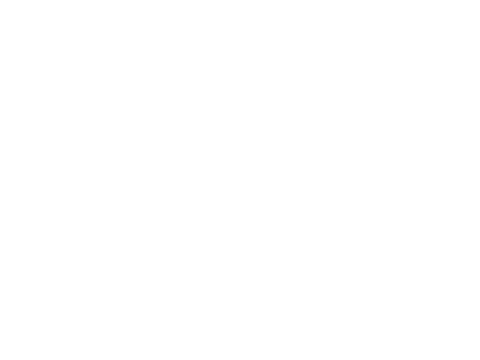

    animalid cohort                                         datasource  \
173     AL13     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

      session  
173  20170803  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed
***** Parsing trials *****


N total response events:  608
N total outcome events:  608
Found and removed 159 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL13_170803.mwk
N valid trials: 449
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting stats by transform ...
[('Blob_2_0', 0.47280334728033474), ('Blob_1_0', 0.5285714285714286)]


<IPython.core.display.Javascript object>


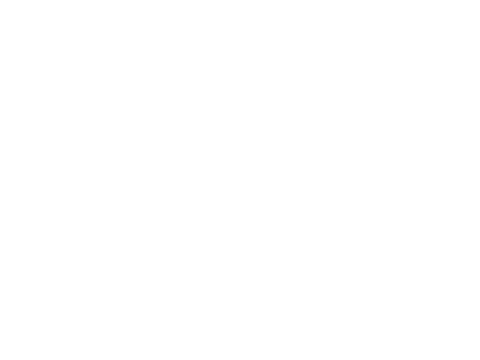

    animalid cohort                                         datasource  \
174     AL13     AL  /n/coxfs01/behavior-data/threeport/cohort_data...   

      session  
174  20170804  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AL/processed
***** Parsing trials *****


N total response events:  858
N total outcome events:  858
Found and removed 143 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL13_170804.mwk
N valid trials: 715
... Getting session summary ...
... Getting stimulus counts ...
... plotting some stats...
... Plotting stats by transform ...
[('Blob_2_0', 0.485), ('Blob_1_0', 0.5523809523809524)]


<IPython.core.display.Javascript object>


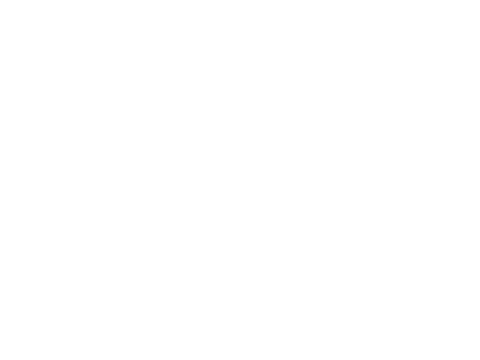

In [60]:
# Process all new sessions:
session_meta = metadata[(metadata.animalid==animalid)] # & (metadata.session==session)]

processed_sessions = pb.process_sessions_mp(new_sessions, session_meta,
                                         #dst_dir=output_figdir,
                                         nprocesses=1,
                                         ignore_flags=ignore_flags,
                                         response_types=response_types,
                                         outcome_types=outcome_types) #, create_new=True)

# Run ALL ANIMALS

In [71]:
output_datadir

'/n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data'

In [115]:
reload(pb)

<module 'parse_behavior' from 'parse_behavior.py'>

In [17]:
cohort='AG'
#animalid = 'AG1'

session_meta = metadata[ (metadata.cohort==cohort) ]
session_meta

,animalid,cohort,datasource,session
4247,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150202
4248,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150203
4249,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150204
4250,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150206
4251,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150209
4252,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150210
4253,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150211
4254,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150212
4255,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150213
4256,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150216


In [18]:
# Get current animal session info:
A = pb.Animal(animalid=animalid, experiment=paradigm) #, output_datadir=output_datadir)
curr_processed_dir = os.path.join(root, paradigm, 'cohort_data', cohort, 'processed')

# --- Create or load animal datafile:
animal_datafile = os.path.join(curr_processed_dir, 'data', '%s.pkl' % animalid)
print("outfile: %s" % animal_datafile)

outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data/AG2.pkl


In [121]:

# --- Process new datafiles / sessions:
all_sessions = metadata[metadata.animalid==animalid]['session'].values
old_sessions = [skey for skey, sobject in A.sessions.items() if sobject is not None]
print("[%s]: Found %i processed sessions." % (animalid, len(old_sessions)))
new_sessions = [s for s in all_sessions if s not in old_sessions]
print("[%s]: There are %i out of %i found session datafiles to process." % (A.animalid, len(new_sessions), len(all_sessions)))
new_sessions[0:5]

[AG1]: Found 0 processed sessions.
[AG1]: There are 205 out of 205 found session datafiles to process.


[20150202, 20150203, 20150204, 20150206, 20150209]

In [127]:
# dfn = session_meta[session_meta.session==20150202]['datasource'].values[0]
# dfn

'/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG1_150202.mwk'

In [15]:
session_meta

,animalid,cohort,datasource,session
4247,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150202
4248,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150203
4249,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150204
4250,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150206
4251,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150209
4252,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150210
4253,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150211
4254,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150212
4255,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150213
4256,AG10,AG,/n/coxfs01/behavior-data/threeport/cohort_data...,20150216


In [16]:
checkdata=[]
for dfn in session_meta[session_meta.animalid=='AG2']['datasource'].values:
    df = pymworks.open(dfn)
    if 'nofeedback_depth_rotation_min' not in df.get_codec().values():
        print dfn
        checkdata.append(dfn)



/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150202.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150203.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150204.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150206.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150209.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150210.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150211.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150212.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150213.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150216.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150217.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150218.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150219.mwk
/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150220.mwk
/n/coxfs01/behavior-data/threeport

KeyboardInterrupt: 

In [ ]:
checkdata

In [19]:
for (cohort, animalid), session_meta in metadata[metadata['cohort']=='AG'].groupby(['cohort', 'animalid']):

    
    print("***********************************************")
    print("ANIMAL:  %s" % animalid)
    print("***********************************************")

    # Get current animal session info:
    A = pb.Animal(animalid=animalid, experiment=paradigm) #, output_datadir=output_datadir)
    curr_processed_dir = os.path.join(root, paradigm, 'cohort_data', cohort, 'processed')

    # --- Create or load animal datafile:
    animal_datafile = os.path.join(curr_processed_dir, 'data', '%s.pkl' % animalid)
    print("outfile: %s" % animal_datafile)
    
    # --- Check if processed file exists -- load or create new.
    create_new = False
    if os.path.exists(animal_datafile):
        try:
            with open(animal_datafile, 'rb') as f:
                A = pkl.load(f)   
        except EOFError:
            create_new = True

    # --- Process new datafiles / sessions:
    all_sessions = metadata[metadata.animalid==animalid]['session'].values
    old_sessions = [skey for skey, sobject in A.sessions.items() if sobject is not None]
    print("[%s]: Found %i processed sessions." % (animalid, len(old_sessions)))
    new_sessions = [s for s in all_sessions if s not in old_sessions]
    print("[%s]: There are %i out of %i found session datafiles to process." % (A.animalid, len(new_sessions), len(all_sessions)))

    # Process all new sessions:
    #session_meta = metadata[(metadata.animalid==animalid)] # & (metadata.session==session)]
    processed_sessions = pb.process_sessions_mp(new_sessions, session_meta,
                                             #dst_dir=output_figdir,
                                             nprocesses=1,
                                             ignore_flags=ignore_flags,
                                             response_types=response_types,
                                             outcome_types=outcome_types) #, create_new=True)

    # Update animal sessions dict:
    for datestr, S in processed_sessions.items():
        A.sessions.update({datestr: S})

    # Save to disk:
    try:
        with open(animal_datafile, 'wb') as f:
            pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)
    except PicklingError:
        print("Unable to pkl: New sessions are not the same class as old sessions.")
        print("Reprocessing %i old sessions..." % len(processed_sessions))
        for session in old_sessions:
            curr_sessionmeta = session_meta[session_meta.session==session] #session_info[datestr]
            S = pd.process_session(curr_sessionmeta)
            A.sessions[session] = S

        with open(animal_datafile, 'wb') as f:
            pkl.dump(A, f, protocol=pkl.HIGHEST_PROTOCOL)

    print("[%s] ~~~ processing complete! ~~~" % A.animalid)



***********************************************
ANIMAL:  AG1
***********************************************
outfile: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data/AG1.pkl
[AG1]: Found 0 processed sessions.
[AG1]: There are 205 out of 205 found session datafiles to process.
     animalid cohort                                         datasource  \
4557      AG1     AG  /n/coxfs01/behavior-data/threeport/cohort_data...   

       session  
4557  20150202  
Saving processed output to: /n/coxfs01/behavior-data/threeport/cohort_data/AG/processed
***** Parsing trials *****


Process Process-1:
Traceback (most recent call last):
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "parse_behavior.py", line 308, in parser
    create_new=create_new)
  File "parse_behavior.py", line 388, in process_session
    outcome_types = ['success', 'ignore', 'failure'])
  File "parse_behavior.py", line 104, in parse_trials
    ignore_flags=ignore_flags)
  File "parse_behavior.py", line 444, in parse_trials
    always_feedback = False
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/io/datafile.py", line 334, in get_events
    codes = key_to_code(key, self.to_code)
  File "/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/io/datafile.py", line 17, in key_to_code
    re

KeyboardInterrupt: 

In [74]:
# Reprocess buggy datafiles:

# processed_sessions = {}
# for datestr in new_sessions:
#     session_meta = session_info[datestr]
#     S = process_session(session_meta, 
#                         output_figdir=output_figdir,
#                         ignore_flags=ignore_flags,
#                         response_types=response_types, 
#                         outcome_types=outcome_types)
#     processed_sessions[datestr] = S

{'session': '20151119', 'datasource': ['/n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_151119.mwk'], 'animal': 'AG2'}
***** Parsing trials *****
... Getting session summary ...
... Getting stimulus counts ...
{'session': '20151118', 'datasource': ['/n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_151118.mwk'], 'animal': 'AG2'}
***** Parsing trials *****
... Getting session summary ...
... Getting stimulus counts ...
{'session': '20151120', 'datasource': ['/n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_151120.mwk'], 'animal': 'AG2'}
***** Parsing trials *****
N total response events:  0
N total outcome events:  0
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_151120.mwk
N valid trials: 0
... Getting session summary ...
... Getting stimulus counts ...


In [66]:
animal_datafile

'/n/coxfs01/behavior-data/threeport/cohort_data/AG/processed/data/AL1.pkl'

In [68]:
A.animalid

'AL1'

#### Save processed sessions to animal object in case MP errors out:

In [70]:
curr_processed_dir = animal_datafile.split('/data')[0]
tmp_processed_sessions = glob.glob(os.path.join(curr_processed_dir, 'figures', 
                                                'tmp_files', 'proc_%s_*.pkl' % A.animalid))
print("Found %i processed sessions in tmp dir." % len(tmp_processed_sessions))

for tmpfile in tmp_processed_sessions:
    with open(tmpfile, 'rb') as f:
        tmpS = pkl.load(f)
    session = os.path.splitext(os.path.split(tmpfile)[-1])[0].split('_')[2]
    #print datestr
    A.sessions.update({datestr: tmpS})


Found 0 processed sessions in tmp dir.


# Load single file and analyze df

In [100]:
dfn = sorted(session_meta['datasource'].values, key=natural_keys)[0]
print(dfn)



/n/coxfs01/behavior-data/threeport/cohort_data/AL/raw/AL13_170914.mwk


In [10]:
import pymworks
reload(pb)

<module 'parse_behavior' from 'parse_behavior.pyc'>

In [11]:
dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_160126.mwk' #160126.mwk' #AG2_150216

dfn = '/n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150209.mwk'  #AG2_150209

In [19]:
df = pymworks.open(dfn)

In [20]:
if ignore_flags is None:
    codec = df.get_codec()
    ignore_flags = []
    all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
    for fl in all_flags:
        evs = df.get_events(fl)
        vals = list(set([v.value for v in evs]))
        if len(vals) > 1 or len(evs) > 5:
            ignore_flags.append(fl)

In [21]:
# Get run bounds:
bounds = pb.get_run_time(df)
bound = bounds[0]

In [22]:
# Get all response evs and outcomes evs in run
response_evs = [e for e in df.get_events(response_types) if (bound[0] < e['time'] < bound[1]) and e.value is not None and e.value != 0] # in [0, None]]    
outcome_evs = [e for e in df.get_events(outcome_types) if (bound[0] < e['time'] < bound[1]) and e.value is not None and e.value != 0] #not in [0, None]]  
print(len(response_evs), len(outcome_evs))

# Sync response events to true outcome events:  response occurs before outcome, outcome is the master
matched_responses = pymworks.events.utils.sync(response_evs, outcome_evs, direction=-1, mkey=lambda x: x.time)
matched_responses = [m for m in matched_responses if m is not None]
print "N total outcome events: ", len(matched_responses)

(8, 9)
N total outcome events:  7


In [23]:
remove_orphans = True

In [26]:
outcome_evs

[Event[code=191, name=failure, time=1183747153, value=1],
 Event[code=192, name=ignore, time=1183747154, value=1],
 Event[code=191, name=failure, time=1184032688, value=1],
 Event[code=192, name=ignore, time=1184032690, value=1],
 Event[code=191, name=failure, time=1195548985, value=1],
 Event[code=192, name=ignore, time=1195548987, value=1],
 Event[code=190, name=success, time=1322783159, value=1],
 Event[code=192, name=ignore, time=2090520661, value=1],
 Event[code=192, name=ignore, time=2682626871, value=1],
 Event[code=192, name=ignore, time=4220987167, value=1],
 Event[code=192, name=ignore, time=4970757769, value=1],
 Event[code=192, name=ignore, time=5400366166, value=1],
 Event[code=192, name=ignore, time=6499837002, value=1]]

In [24]:
# Get run bounds:
bounds = pb.get_run_time(df)
stim_blacklists = [
    lambda s: (('type' in s.keys()) and (s['type'] == 'blankscreen')),
    ]

trials = []; flag_list = []; flags = {};
for bound in bounds:
    # Get display events:
    tmp_devs = df.get_events('#stimDisplayUpdate')                     
    tmp_devs = [i for i in tmp_devs if bound[0] <= i['time']<= bound[1]] 

    # Get behavior flags:
    codec = df.get_codec()
    all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
    flag_names = [f for f in all_flags if f not in ignore_flags]
    tmp_flags = dict((flag, None) for flag in flag_names)
    for flag in flag_names:
        if flag == 'FlagNoFeedbackInCurrentTrial': continue
        found_values = [e.value for e in df.get_events(flag) if bound[0] <= e.time <=bound[1]]
        if (len(found_values) > 1) or (len(list(set(found_values)))) > 1:
            print("More than 1 value found for flag: %s" % flag)
            tmp_flags[flag] = int(found_values[-1])
        elif (len(found_values) == 1) or (len(list(set(found_values)))) == 1:
            tmp_flags[flag] = int(found_values[0])
        else:
            tmp_flags.pop(flag)

    flag_list.append(tmp_flags)               # Add current flag values to flags list
    tmp_flags.update({'run_bounds': bound})   # Add boundary time to flag info 

    # Check for valid response types and get all response events:
    response_types = [r for r in response_types if r in codec.values()]
    response_evs = [e for e in df.get_events(response_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value==1]    
    outcome_evs = [e for e in df.get_events(outcome_types) if e.value==1] #if (bound[0] < e['time'] < bound[1]) and e.value is not None and e.value != 0] #not in [0, None]]  
    print(len(response_evs), len(outcome_evs))

    # Sync response events to true outcome events:  response occurs before outcome, outcome is the master
    #matched_responses = pymworks.events.utils.sync(response_evs, outcome_evs, direction=-1, mkey=lambda x: x.time)
    #matched_outcomes = pymworks.events.utils.sync(outcome_evs, response_evs, direction=1, mkey=lambda x: x.time)
    #matched_outcomes = [m for m in matched_outcomes if m is not None]
    #print "N total outcome events: ", len(matched_outcomes)
    #print "N total outcome events: ", len(matched_responses)

    #matched_stims = pymworks.events.utils.sync(tmp_devs, matched_responses, direction=-1, mkey=lambda x: x.time)
    #print("n stim evs:", len(matched_stims))
    # Convert to trials: match stimulus events and response events:
    outcome_key = 'response'
    responses = pb.to_trials(tmp_devs, response_evs, outcome_key=outcome_key,
                                               duration_multiplier=1.,
                                               stim_blacklists=stim_blacklists,
                                               remove_unknown=True)
    
#     responses = pb.to_trials(tmp_devs, outcomes, outcome_key=outcome_key,
#                                                duration_multiplier=1.0,
#                                                stim_blacklists=None,
#                                                remove_unknown=False)

    # **sync outcome events to response events as master (direction 1=slave after master, -1=slave before master)
    #outcome_evs = [e for e in df.get_events(outcome_types) if (bound[0] < e['time'] < bound[1]) and e.value!=0]
    outcomes = pymworks.events.utils.sync(outcome_evs, responses, direction=1, mkey=lambda x: x['response_time'])
    #outcomes = pymworks.events.utils.sync(response_evs, responses, direction=-1, mkey=lambda x: x['response_time'])

    assert len(responses) == len(outcomes), "**ERROR:  N responses != N outcomes"
    tmp_trials = copy.copy(responses)
    for trial_ix, (response, outcome) in enumerate(zip(responses, outcomes)):
        if outcome is not None:
            tmp_trials[trial_ix].update({'outcome': outcome.name, 'outcome_time': outcome.time}) #['outcome']})
        else:
            tmp_trials[trial_ix].update({'outcome': 'unknown'})

    # Get rid of display events without known outcome within 'duration_multiplier' time
    if remove_orphans:                                                  
        orphans = [(i,x) for i,x in enumerate(tmp_trials) if\
                    x['outcome']=='unknown' or x['%s' % outcome_key]=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['outcome']=='unknown']
        tmp_trials = [t for t in tmp_trials if not t['%s' % outcome_key]=='unknown']

        print "Found and removed %i orphan stimulus events in file %s" % (len(orphans), df.filename)
        print "N valid trials: %i" % len(tmp_trials)

    # Add current trials in chunk to trials list:
    trials.extend(tmp_trials)


(10, 13)
Found and removed 0 orphan stimulus events in file /n/coxfs01/behavior-data/threeport/cohort_data/AG/raw/AG2_150209.mwk
N valid trials: 1


In [ ]:
df.get_events()

In [113]:
#  231: 'nofeedback_depth_rotation_min',
#  232: 'nofeedback_depth_rotation_max',
#  233: 'nofeedback_size_min',
#  234: 'nofeedback_size_max',

no_fb_params_tmp = df.get_events(['nofeedback_size_min',
                               'nofeedback_size_max',
                               'nofeedback_depth_rotation_min',
                               'nofeedback_depth_rotation_max'])
fb_info = list(set([(e.name, e.value) for e in no_fb_params_tmp]))
no_fb = {}
for fb in fb_info:
    param = '_'.join(fb[0].split('_')[1:-1])
    if param not in no_fb.keys():
        no_fb[param] = [fb[1]]
    else:
        no_fb[param].append(fb[1])
no_fb

{'depth_rotation': [-60, 0], 'size': [15, 30]}

In [114]:
for trial in trials:
    stim_aspect = [v.value for v in df.get_events('StimAspectRatio')][-1]
    assert trial['response_time'] < trial['outcome_time'], "**ERROR: Mismatch in response/outcome alignment"
    
    # Supplement trial info
    stimname = trial['name'].split(' ')[0].split('.png')[0]
    #print(stimname)
    trial['name'] = stimname
    trial['depth_rotation'] = int(stimname.split('_y')[-1]) #Blob_N2_CamRot_y-45
    trial['size'] = round(trial['size_x']/stim_aspect, 1)
    
    # Check if no feedback
    trial['no_feedback'] = all([np.min(lims) < trial[k] < np.max(lims) for k, lims in no_fb.items()])

# Combine all flag states:
for fi, flag_dict in enumerate(flag_list):
    if fi == 0:
        flags = copy.copy(flag_dict)
    else:
        for flag_name, flag_value in flag_dict.items():
            existing_value = flags[flag_name] #.value()
            if flag_value == existing_value:
                continue
            if not isinstance(flags[flag_name], list):
                flags[flag_name] = list(flags[flag_name])
            flags[flag_name].append(flag_value)

In [115]:
tdf = pd.DataFrame({'outcome': [t['outcome'] for t in trials],
 'response': [t['response'] for t in trials],
 'no_feedback': [t['no_feedback'] for t in trials]}, index=np.arange(0, len(trials)))



In [116]:
tdf.groupby(['outcome']).count()

,no_feedback,response
outcome,,
failure,148,148
success,564,564


### Test w/ FlagNoFeedbackInCurrentTrial

In [73]:
revs = [e for e in df.get_events(response_types) if e.value==1] # in [0, None]]    
len(revs)

716

In [17]:
len([t for t in trials if t['no_feedback']])


80

In [101]:
[ti for ti, trial in enumerate(trials) if trial['no_feedback']]


[22,
 34,
 37,
 41,
 43,
 56,
 61,
 75,
 76,
 86,
 97,
 98,
 108,
 117,
 121,
 122,
 131,
 136,
 161,
 188,
 202,
 204,
 210,
 213,
 219,
 222,
 224,
 226,
 241,
 257,
 265,
 276,
 288,
 304,
 318,
 321,
 325,
 326,
 328,
 332,
 345,
 354,
 393,
 400,
 407,
 410,
 428,
 431,
 436,
 450,
 461,
 479,
 495,
 498,
 506,
 511,
 514,
 520,
 528,
 532,
 546,
 549,
 561,
 569,
 571,
 579,
 595,
 606,
 609,
 611,
 614,
 620,
 651,
 660,
 662,
 677,
 684,
 689,
 691,
 711]

In [101]:
#fb_evs = Announce_TrialNoFeedback
fb_evs = df.get_events('Announce_TrialNoFeedback')


In [104]:
df.get_events('FlagNoFeedbackInCurrentTrial')


[Event[code=75, name=FlagNoFeedbackInCurrentTrial, time=678069902927, value=0],
 Event[code=75, name=FlagNoFeedbackInCurrentTrial, time=678070282574, value=0],
 Event[code=75, name=FlagNoFeedbackInCurrentTrial, time=678105491144, value=0]]

In [103]:
NB = []
for tix, trial in enumerate(trials[0:330]):
    ttime = (trial['time'], trial['time'] + trial['duration'])
    nofeedback = [e.value for e in fb_evs if \
                  ttime[0]-1000000 <= e.time <=ttime[1] ] #and e.value==1]
                  #ttime[0]-1000000 <= e.time <=ttime[1] ] #and e.value==1]
    tstart = [e.value for e in df.get_events('Announce_TrialStart') if \
                  ttime[0]-1000000 <= e.time <=ttime[1] ] #and e.value==1]
                  #ttime[0]-1000000 <= e.time <=ttime[1] ] #and e.value==1]
    if any(nofeedback) or trial['no_feedback']:
        print (tix, nofeedback, tstart, trial['no_feedback'])
        NB.append((tix, nofeedback, tstart, trial['no_feedback'])) #len(nofeedback)

(22, [0, 1, 0], [0, 1, 0], True)
(34, [0, 1, 0], [0, 1, 0], True)
(37, [0, 1, 0], [0, 1, 0], True)
(41, [0, 1, 0], [0, 1, 0], True)
(43, [0, 1, 0, 0], [0, 1, 0, 0], True)
(56, [0, 1, 0], [0, 1, 0], True)
(61, [0, 1, 0], [0, 1, 0], True)
(75, [0, 1, 0, 1], [1, 0], True)
(76, [0, 1, 0], [1, 0], True)
(86, [0, 1, 0], [0, 1, 0], True)
(97, [0, 0, 1, 0, 1], [0, 0, 1, 0], True)
(98, [0, 1, 0], [1, 0], True)
(108, [0, 1, 0], [0, 1, 0], True)
(117, [0, 1, 0, 0], [0, 1, 0, 0], True)
(121, [0, 1, 0, 1], [1, 0], True)
(122, [0, 1, 0], [1, 0], True)
(131, [0, 1, 0], [0, 1, 0], True)
(136, [0, 1, 0, 0], [0, 1, 0, 0], True)
(161, [0, 1, 0], [1, 0], True)
(188, [0, 1, 0], [0, 1, 0], True)
(190, [0, 0, 0, 1, 0, 0], [0, 0, 0, 0, 0, 1], False)
(202, [0, 1, 0], [0, 1, 0], True)
(204, [0], [1, 0], True)
(210, [0, 1, 0, 0, 0], [0, 1, 0, 0, 0], True)
(213, [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], True)
(216, [0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0,

KeyboardInterrupt: 

In [63]:
{'depth_rotation': [-60, 0], 'size': [15, 30]} 
# SIZE:  20, 25
# ROT:  -15, -30, -45

{'depth_rotation': [-60, 0], 'size': [15, 30]}

In [64]:
len(NB)

41

In [25]:
announce_start_evs = df.get_events(['Announce_TrialStart'])
announce_starts = sorted([ev for ev in announce_start_evs if ev.value==1], key=lambda e: e.time)
announce_starts

[Event[code=80, name=Announce_TrialStart, time=1320630839, value=1],
 Event[code=80, name=Announce_TrialStart, time=2086231196, value=1],
 Event[code=80, name=Announce_TrialStart, time=2678335287, value=1],
 Event[code=80, name=Announce_TrialStart, time=4216703081, value=1],
 Event[code=80, name=Announce_TrialStart, time=4966471217, value=1],
 Event[code=80, name=Announce_TrialStart, time=5396087455, value=1],
 Event[code=80, name=Announce_TrialStart, time=6495543189, value=1]]

In [32]:
for a, o in zip(announce_start_evs, oevs):
    print (o.time - a.time) / 1E6


139.036174
906.488153
1487.078079
2900.356328
3642.401778
3314.13497
4408.298367


In [28]:
outcome_evs

[Event[code=191, name=failure, time=1183747153, value=1],
 Event[code=192, name=ignore, time=1183747154, value=1],
 Event[code=191, name=failure, time=1184032688, value=1],
 Event[code=192, name=ignore, time=1184032690, value=1],
 Event[code=191, name=failure, time=1195548985, value=1],
 Event[code=192, name=ignore, time=1195548987, value=1],
 Event[code=190, name=success, time=1322783159, value=1],
 Event[code=192, name=ignore, time=2090520661, value=1],
 Event[code=192, name=ignore, time=2682626871, value=1],
 Event[code=192, name=ignore, time=4220987167, value=1],
 Event[code=192, name=ignore, time=4970757769, value=1],
 Event[code=192, name=ignore, time=5400366166, value=1],
 Event[code=192, name=ignore, time=6499837002, value=1]]

In [31]:
oevs = [i for i in outcome_evs if i.time > announce_starts[0].time]

In [18]:
#### Get trial starts
announce_start_evs = df.get_events(['Announce_TrialStart'])
announce_starts = sorted([ev for ev in announce_start_evs if ev.value==1], key=lambda e: e.time)

# Get other events
stim = pymworks.events.display.to_stims(tmp_devs, as_dicts=True, blacklist=stim_blacklists)

#print(len(announce_starts), len(stim))
assert len(stim) == len(announce_starts), "UHOH: Found %i starts and %i stimulus events" % (len(announce_starts), len(stim))

test
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
passing
pas

In [23]:
#### For each start, we want to found its end (if it exists) and the outcome (if it exists)
announce_end_evs = df.get_events(['Announce_TrialEnd'])
announce_ends = sorted([ev for ev in announce_end_evs], key=lambda e: e.time)
#len(announce_ends)

outcome_es = df.get_events(['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore'])
outcome_evs = sorted([ev for ev in outcome_es], key=lambda e: e.time)
#len(outcome_evs)

nofb_es = df.get_events(['FlagNoFeedbackInCurrentTrial'])
no_feedback_evs = sorted([ev for ev in nofb_es], key=lambda e: e.time)
#len(outcome_evs)

lick_events = ['LickInput1', 'LickInput3']

In [27]:
too_soon = df.get_events('TooFast_time')[-1].value/1E6
too_soon

0.35

In [25]:
lick_events = ['LickInput1', 'LickInput3']
outcome_events = ['success', 'ignore', 'failure']
response_events = ['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']



In [21]:
len(stim)

854

In [61]:
no_end=True;no_outcome=True;
tblocks=[]
trials=[]
ei = 0; oi=0;
out_ev=outcome_evs[0]
end_ev=announce_ends[0]
fb_ev=no_feedback_evs[0]
#for ai, (aev, sdict) in enumerate(zip(sorted(announce_starts, key=lambda x: x.time), stim)):
for ai, aev in enumerate(sorted(announce_starts[0:100], key=lambda x: x.time)):
    if ai % 20 == 0:
        print('...%i of %i' % (int(ai+1), len(announce_starts)))
    if ai < len(announce_starts)-1:
        tbin = (aev.time, announce_starts[ai+1].time)
    else:
        tbin = (aev.time, bound[-1])
    
    
    no_end=True; abort=False; no_outcome=True; no_feedback_value=-1;
    event_iter = iter(announce_ends[ei:])
    while no_end and (end_ev.time < tbin[1]):
        try:
            # get the next item
            end_ev = next(event_iter)
            end_time = end_ev.time
            ei += 1
            no_end = end_ev.value==0
        except StopIteration:
            if ei==len(announce_ends):
                end_time = bound[-1]
            else:
                abort=True
            #end_ev = None
            break
#     out_iter = iter(outcome_evs[oi:])
#     while no_outcome and (out_ev.time < tbin[1]):
#         try:
#             # get the next item
#             out_ev = next(out_iter)
#             oi += 1
#             no_outcome = out_ev.value==0
#         except StopIteration:
#             # if StopIteration is raised, break from loop
#             abort=True
#             #outcome = None
#             break
            
#     fb_iter = iter(no_feedback_evs[fi-1:])
#     fb_value=[]
#     while fb_ev.time < tbin[1]:
#         print(fb_ev.value)
#         try:
#             # get the next item
#             fb_ev = next(fb_iter)
#             fi += 1
#             fb_value.append(fb_ev.value)# = out_ev.value==0
#         except StopIteration:
#             # if StopIteration is raised, break from loop
#             no_feedback_value = 0 if len(fb_value)==0 else max(fb_value)
#             #outcome = None
#             break
    

#     #lick_ts = df.get_events(lick_events, time_range=(aev.time, end_ev.time))
#     if abort:
#         outcome='abort'
#         outcome_time = None
#         #out_time=lickt_ts[0].time
#     else:
#         outcome = out_ev.name
#         outcome_time = out_ev.time
        
#     currt=None
    curr_tbin = (aev.time, end_time)
    stim_evs = df.get_events('#stimDisplayUpdate', time_range=curr_tbin)
    lick_evs = df.get_events(lick_events, time_range=curr_tbin)
    response_evs = [e for e in df.get_events(response_events, time_range=curr_tbin) if e.value==1]
    outcome_evs = [e for e in df.get_events(outcome_events, time_range=curr_tbin) if e.value==1]
    no_feedback = any([e.vaue for e in df.get_events('FlagNoFeedbackInCurrentTrial', time_range=curr_tbin)])
    
    if len(lick_evs) > 0:
        first_lick_post = [(r.time - stim_evs[0].time)/1E6 for r in sorted(lick_evs, key=lambda x: x.time)][0]
        if first_lick_post <= too_soon:
            status = 0
        else:
            status = -1
    elif len(lick_evs) == 0 or len(outcome_evs)==0:
        status = -1
    else:
        currt = pb.to_trials(stim_evs, outcome_evs, outcome_key='outcome', remove_unknown=False,
                            stim_blacklists=stim_blacklists, duration_multiplier=1)
        if len(currt)==0:
            currt = None
            status=-2
        else:
            assert len(currt)==1
            currt = currt[0]
            status = 1
        #         #currt.update({'response': outcome.name, 'outcome_time': outcome.time}) #['outcome']})
            #curr_trial = sdict.copy()

            currt.update({'no_feedback': no_feedback,
                          'status': status})

    trials.append(currt)
    
    tblocks.append(pd.DataFrame({'start': aev.time,
                                 'end': end_time, # tbin[1],
                                 #'abort': abort,
                                 'status': status,
                                 'duraton': float((tbin[1]-tbin[0])/1E6)}, index=[ai]))

#     trials.append({'outcome': out_ev.name,
#                      'outcome_time': out_ev.time,
#                      'lick_times': lick_ts})
    
tblocks = pd.concat(tblocks, axis=0)

...1 of 854
...21 of 854


KeyboardInterrupt: 

In [63]:
trials

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [59]:
lick_evs

[]

In [31]:
stim_evs

[Event[code=7, name=#stimDisplayUpdate, time=674334669575, value=[{'name': 'BlankScreen', 'color_g': 0.0, 'color_b': 0.0, 'action': 'draw', 'type': 'blankscreen', 'color_r': 0.0}, {'pos_x': 0.0, 'pos_y': 0.0, 'name': 'Blob_N2_CamRot_y-60.png 1', 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N2_CamRot_y-60.png', 'file_hash': '332a7afdb7fdd025f644c3546d98017ad57f8dc2', 'size_x': 26.204999923706055, 'size_y': 26.204999923706055, 'action': 'draw', 'rotation': 0.0, 'type': 'image'}]]]

In [33]:
import pymworks as pymw

In [34]:
reload(pymw)

<module 'pymworks' from '/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/pymworks/__init__.pyc'>

In [395]:
pb.to_trials(stim_evs, outcome_evs, outcome_key='outcome', remove_unknown=False,
                            stim_blacklists=stim_blacklists, duration_multiplier=1)

[]

In [396]:
stim_evs

[Event[code=7, name=#stimDisplayUpdate, time=674334669575, value=[{'name': 'BlankScreen', 'color_g': 0.0, 'color_b': 0.0, 'action': 'draw', 'type': 'blankscreen', 'color_r': 0.0}, {'pos_x': 0.0, 'pos_y': 0.0, 'name': 'Blob_N2_CamRot_y-60.png 1', 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N2_CamRot_y-60.png', 'file_hash': '332a7afdb7fdd025f644c3546d98017ad57f8dc2', 'size_x': 26.204999923706055, 'size_y': 26.204999923706055, 'action': 'draw', 'rotation': 0.0, 'type': 'image'}]]]

In [35]:
pymw.events.display.to_stims(stim_evs, as_dicts=True, 
                      blacklist=stim_blacklists)

test
passing


[]

In [37]:
blacklist = stim_blacklists

In [38]:
if not isinstance(blacklist, (tuple, list)):
    blacklist = (blacklist, )

In [45]:
stims = []
onscreen = []
for e in sorted(stim_evs, key=lambda e: e.time):
    
    if e.value is None:
        logging.warning("Encountered event with value == None")
        if onscreen != []: #{}:
            print "onscreen", onscreen
            logging.error("Event.value == None with items on screen")
        continue
    current = []
    if hasattr(e.value, '__getitem__'):
        stimulus = None
        pixelclock = None
        for stim in e.value:
            #print stim
            if not isinstance(stim, dict) or \
                    any([t(stim) for t in blacklist]):
                print "passing"
                continue
            if ('name' in stim.keys()) and (stim['name'] == 'pixel clock'):
                pixelclock = stim
            else:
                if stimulus is not None:
                    logging.warning(
                        "Two stimuli onscreen: %s, %s"
                        % (stimulus, stim))
                print("adding")
                stimulus = stim
        if stimulus is not None:
            current.append(pymworks.events.display.Stimulus(e.time, stimulus, pixelclock))
    newstims, onscreen = pymw.events.display.find_stims(onscreen, current, e.time)
    stims += newstims

passing
adding


In [52]:
onscreen

In [46]:
def find_stims(onscreen, current, time):
    """ Return a list of stims that disappeared and the updated buffer"""
    stims = []
    for s in onscreen[:]:
        if s not in current:
            s.duration = time - s.time
            stims.append(copy.copy(s))
            # remove it from onscreen
            onscreen.remove(s)
    for s in current:
        if s not in onscreen:
            onscreen.append(s)
    return stims, onscreen


{'action': 'draw',
 'file_hash': '332a7afdb7fdd025f644c3546d98017ad57f8dc2',
 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N2_CamRot_y-60.png',
 'name': 'Blob_N2_CamRot_y-60.png 1',
 'pos_x': 0.0,
 'pos_y': 0.0,
 'rotation': 0.0,
 'size_x': 26.204999923706055,
 'size_y': 26.204999923706055,
 'type': 'image'}

In [47]:
current[0].to_dict()

{'action': 'draw',
 'duration': None,
 'file_hash': '332a7afdb7fdd025f644c3546d98017ad57f8dc2',
 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N2_CamRot_y-60.png',
 'name': 'Blob_N2_CamRot_y-60.png 1',
 'pos_x': 0.0,
 'pos_y': 0.0,
 'rotation': 0.0,
 'size_x': 26.204999923706055,
 'size_y': 26.204999923706055,
 'time': 674334669575,
 'type': 'image'}

In [48]:
onscreen

In [51]:
stims

[]

In [303]:
no_end=True;no_outcome=True;
tblocks=[]
trials=[]
ei = 0; oi=0;
out_ev=outcome_evs[0]
end_ev=announce_ends[0]
fb_ev=no_feedback_evs[0]
for ai, (aev, sdict) in enumerate(zip(sorted(announce_starts, key=lambda x: x.time), stim)):
    if ai % 20 == 0:
        print('...%i of %i' % (int(ai+1), len(announce_starts)))
    if ai < len(announce_starts)-1:
        tbin = (aev.time, announce_starts[ai+1].time)
    else:
        tbin = (aev.time, bound[-1])
    
    
    no_end=True; abort=False; no_outcome=True; no_feedback_value=-1;
    event_iter = iter(announce_ends[ei:])
    while no_end and (end_ev.time < tbin[1]):
        try:
            # get the next item
            end_ev = next(event_iter)
            end_time = end_ev.time
            ei += 1
            no_end = end_ev.value==0
        except StopIteration:
            if ei==len(announce_ends):
                end_time = bound[-1]
            else:
                abort=True
            #end_ev = None
            break
     
    out_iter = iter(outcome_evs[oi:])
    while no_outcome and (out_ev.time < tbin[1]):
        try:
            # get the next item
            out_ev = next(out_iter)
            oi += 1
            no_outcome = out_ev.value==0
        except StopIteration:
            # if StopIteration is raised, break from loop
            abort=True
            #outcome = None
            break
            
    fb_iter = iter(no_feedback_evs[fi-1:])
    fb_value=[]
    while fb_ev.time < tbin[1]:
        print(fb_ev.value)
        try:
            # get the next item
            fb_ev = next(fb_iter)
            fi += 1
            fb_value.append(fb_ev.value)# = out_ev.value==0
        except StopIteration:
            # if StopIteration is raised, break from loop
            no_feedback_value = 0 if len(fb_value)==0 else max(fb_value)
            #outcome = None
            break
    

    #lick_ts = df.get_events(lick_events, time_range=(aev.time, end_ev.time))
    if abort:
        outcome='abort'
        outcome_time = None
        #out_time=lickt_ts[0].time
    else:
        outcome = out_ev.name
        outcome_time = out_ev.time
        
#     currt=None
#     stim_evs = df.get_events('#stimDisplayUpdate', time_range=tbin)
#     lick_evs = df.get_events(lick_events, time_range=tbin)
    #response_evs = [e for e in df.get_events(response_events, time_range=tbin) if e.value==1]
    #outcome_evs = [e for e in df.get_events(outcome_events, time_range=tbin) if e.value==1]

#     if len(outcome_evs)==0:
#         first_lick_post = [(r.time - stim_evs[0].time)/1E6 for r in sorted(lick_evs, key=lambda x: x.time)][0]
#         if first_lick_post <= too_soon:
#             status = 0
#         else:
#             status = -1
#     else:
#         status = 1
#         currt = pb.to_trials(stim_evs, outcome_evs, outcome_key='outcome', remove_unknown=remove_unknown,
#                             stim_blacklists=stim_blacklists, duration_multiplier=2)
        
#         #currt.update({'response': outcome.name, 'outcome_time': outcome.time}) #['outcome']})
    curr_trial = sdict.copy()
    curr_trial.update({'abort': abort,
                       'outcome': outcome,
                       'response_time': outcome_time,
                       'start_time': aev.time,
                       'end_time': end_time,
                        'no_feedback': no_feedback_value})
    
    trials.append(curr_trial)
    
    tblocks.append(pd.DataFrame({'start': aev.time,
                                 'end': end_time, # tbin[1],
                                 'abort': abort,
                                 'outcome': outcome,
                                 'duraton': float((tbin[1]-tbin[0])/1E6)}, index=[ai]))

#     trials.append({'outcome': out_ev.name,
#                      'outcome_time': out_ev.time,
#                      'lick_times': lick_ts})
    
tblocks = pd.concat(tblocks, axis=0)

...1 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...21 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...41 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...61 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...81 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...101 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...121 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...141 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...161 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...181 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...201 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...221 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...241 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...261 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...281 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...301 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...321 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...341 of 854
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
...361 of 854
0
0
0
0
0
0
0
0
0
0


In [309]:
[t for t in trials if t['no_feedback']==0]

[{'abort': False,
  'action': 'draw',
  'duration': 783076,
  'end_time': 674332708699,
  'file_hash': '43b41be240c1fac0a4385f97f9fddf709f106f2f',
  'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N1_CamRot_y60.png',
  'name': 'Blob_N1_CamRot_y60.png 2',
  'no_feedback': 0,
  'outcome': 'ignore',
  'pos_x': 0.0,
  'pos_y': 0.0,
  'response_time': 674286387131,
  'rotation': 0.0,
  'size_x': 26.204999923706055,
  'size_y': 26.204999923706055,
  'start_time': 674330100468,
  'time': 674330620907,
  'type': 'image'},
 {'abort': False,
  'action': 'draw',
  'duration': 5065000,
  'end_time': 674339725047,
  'file_hash': '332a7afdb7fdd025f644c3546d98017ad57f8dc2',
  'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRa

In [305]:
tblocks.head()

,abort,duraton,end,outcome,start
0,False,4.048415,674332708699,ignore,674330100468
1,False,13.784002,674339725047,ignore,674334148883
2,False,6.615994,674351986188,ignore,674347932885
3,False,8.019872,674361250980,Announce_AcquirePort1,674354548879
4,False,2.152578,674363416151,Announce_AcquirePort1,674362568751


In [306]:
783076/1E6

0.783076

In [285]:
tblocks[tblocks['abort']==True]


,abort,duraton,end,outcome,start
853,True,140.70119,681531458237,abort,681390757047


In [262]:
tblocks.groupby(['outcome']).count()


,abort,duraton,end,start
outcome,,,,
Announce_AcquirePort1,474,474,474,474
Announce_AcquirePort3,375,375,375,375
abort,1,1,1,1
ignore,4,4,4,4


In [258]:
474 + 375 + 1 + 4


854

In [259]:
len(ann_starts)

854

In [239]:
time_bw_starts = np.diff([e.time for e in sorted(ann_starts, key=lambda x: x.time)])/1E6
time_bw_starts.min(), time_bw_starts.max()

(1.759282, 254.174531)

In [156]:
stim_evs = df.get_events('#stimDisplayUpdate', time_range=tbin)

outcome_events = ['success', 'ignore', 'failure']
outcome_evs = df.get_events(outcome_events, time_range=tbin)
if len(outcome_evs) == 0:
    abort = True

tmptrials = pb.to_trials(stim_evs, outcome_events, remove_unknown=True,
              duration_multiplier=2, stim_blacklists=stim_blacklists)

AssertionError: 

In [174]:
[(r.time - stim_evs[0].time)/1E6 for r in lick_evs]


[0.306872, 0.314853, 0.610864, 0.618868]

In [180]:
currt=None
stim_evs = df.get_events('#stimDisplayUpdate', time_range=tbin)
lick_evs = df.get_events(lick_events, time_range=tbin)
response_evs = [e for e in df.get_events(response_events, time_range=tbin) if e.value==1]
outcome_evs = [e for e in df.get_events(outcome_events, time_range=tbin) if e.value==1]

if len(outcome_evs)==0:
    first_lick_post = [(r.time - stim_evs[0].time)/1E6 for r in sorted(lick_evs, key=lambda x: x.time)][0]
    if first_lick_post <= too_soon:
        status = 0
    else:
        status = -1
else:
    status = 1
    currt = pb.to_trials(stim_evs, outcome_evs, outcome_key='outcome', remove_unknown=remove_unknown,
                        stim_blacklists=stim_blacklists, duration_multiplier=2)
print(currt)


None


In [160]:

outcome_evs

[]

In [128]:
event_list = ['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore',
              'success', 'ignore', 'failure', 'FlagNoFeedbackInCurrentTrial',
              'LickInput1', 'LickInput2', 'LickInput3', 'Announce_TrialEnd']

In [ ]:
outcome_events = ['success', 'ignore', 'failure']

In [129]:
trial_evs = df.get_events(event_list, time_range=tbin)
#state_names = [ename for ename in event_list if ]
# 'event': [e.name for e in trial_evs],
# 'time': [e.time for e in trial_evs],
# 'value': [e.value for e in trial_evs if 'Lick' not in e.name and e.value!=0]
trial_evs

[Event[code=249, name=LickInput2, time=674330108181, value=997],
 Event[code=249, name=LickInput2, time=674330324158, value=774],
 Event[code=249, name=LickInput2, time=674330332173, value=0],
 Event[code=248, name=LickInput1, time=674331380194, value=107],
 Event[code=248, name=LickInput1, time=674331388162, value=996],
 Event[code=84, name=Announce_AcquirePort1, time=674331388526, value=1],
 Event[code=191, name=failure, time=674331388869, value=1],
 Event[code=248, name=LickInput1, time=674331692147, value=399],
 Event[code=248, name=LickInput1, time=674331700150, value=0],
 Event[code=248, name=LickInput1, time=674331844264, value=242],
 Event[code=248, name=LickInput1, time=674331852171, value=997],
 Event[code=248, name=LickInput1, time=674331932170, value=8],
 Event[code=248, name=LickInput1, time=674332012163, value=946],
 Event[code=248, name=LickInput1, time=674332020148, value=998],
 Event[code=248, name=LickInput1, time=674332092188, value=312],
 Event[code=248, name=LickIn

In [40]:
bounds = pb.get_run_time(df)
boundary = bounds[0]
fb_evs = [e for e in df.get_events('FlagNoFeedbackInCurrentTrial') if boundary[0] <= e.time <=boundary[1]]

for tix, t in enumerate(trials):
    dur_s = t['duration']/1E6
    if dur_s < 0.36:
        print tix, t['outcome']

In [41]:
an_evs = df.get_events('Announce_TrialStart')
fb_evs = df.get_events('FlagNoFeedbackInCurrentTrial')
print len(fb_evs), len(an_evs)


2323 1897


In [42]:
len(trials)

712

In [189]:
trials[214]

{'action': 'draw',
 'depth_rotation': -45,
 'duration': 566480,
 'file_hash': 'cc7369d1b24c148b9d77fd090ab3c90be41e3637',
 'filename': '/var/folders/bq/d_40rj9j1slfyy_dz1h7_7p80000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N1_CamRot_y-45.png',
 'name': 'Blob_N1_CamRot_y-45',
 'no_feedback': True,
 'outcome': 'success',
 'outcome_time': 675868493096,
 'pos_x': 0.0,
 'pos_y': 0.0,
 'response': 'Announce_AcquirePort3',
 'response_time': 675868492803,
 'rotation': 0.0,
 'size': 20.0,
 'size_x': 34.939998626708984,
 'size_y': 34.939998626708984,
 'time': 675867948502,
 'type': 'image'}

In [113]:
incorrect_successes = [t for t in trials if 'Blob_N1_CamRot_y' in t['name'] \
                         and t['outcome']=='Announce_AcquirePort3' \
                         and t['result'] != 'success']
print "Blob1: %i incorrect successes" % len(incorrect_successes)

incorrect_successes = [t for t in trials if 'Blob_N2_CamRot_y' in t['name'] \
                         and t['outcome']=='Announce_AcquirePort1' \
                         and t['result'] != 'success']
print "Blob2: %i incorrect successes" % len(incorrect_successes)

ignore_trials = [t for t in trials if t['outcome'] == 'ignore' or t['response'] == 'ignore']
print "N ignores: %i" % len(ignore_trials)

Blob1: 0 incorrect successes
Blob2: 0 incorrect successes
N ignores: 3


#### Test trial and event parsing

In [ ]:
df.get_events('TooFast_time')

In [ ]:
df.get_events('StimulusPresentation_time')

In [ ]:
codec = df.get_codec()
ignore_flags = []
all_flags = [f for f in codec.values() if 'Flag' in f or 'flag' in f]
for fl in all_flags:
    evs = df.get_events(fl)
    vals = list(set([v.value for v in evs]))
    if len(vals) > 1 or len(evs) > 5:
        ignore_flags.append(fl)
ignore_flags

# If there is no "abort" use "Announce_TrialEnd" -- these should be "aborted" trials:
#resp_types=['success', 'failure', 'ignore'] #, 'Announce_TrialEnd']
resp_types=['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore'] #, 'Announce_TrialEnd']

trials, flags = parse_trials(df, resp_types=resp_types, ignore_flags=ignore_flags)


In [ ]:
trials[0]

In [ ]:
successes = [d for d in df.get_events('success') if boundary[0] < d.time < boundary[1]]
failures = [d for d in df.get_events('failure') if boundary[0] < d.time < boundary[1]]
ignores = [d for d in df.get_events('ignore') if boundary[0] < d.time < boundary[1]]
ntotal = sum([len(successes), len(failures), len(ignores)])

print("Success: %i, Failure: %i, Ignore: %i" % (len(successes), len(failures), len(ignores)))
print("TOTAL: %i" % ntotal)


In [ ]:

successes = [t for t in trials if t['outcome'] == 'success']
failures = [t for t in trials if t['outcome'] == 'failure']
ignores = [t for t in trials if t['outcome'] == 'ignore']

ntotal = len(trials)

print("Success: %i, Failure: %i, Ignore: %i" % (len(successes), len(failures), len(ignores)))
print("TOTAL: %i" % ntotal)


In [ ]:
choice_types = ['success', 'failure', 'ignore']
aborted = [t for t in trials if t['outcome'] not in choice_types]
print("Aborted: %i" % len(aborted))

In [ ]:
ignore_evs = [d for d in df.get_events('ignore') if boundary[0] <= d.time <= boundary[1]]

In [ ]:
boundary

In [ ]:
[(d.time-1903319378052 ) / 1E6 for d in ignore_evs]

##### Identify NoFeedback Trials:

In [ ]:
fb_evs = [e for e in df.get_events('FlagNoFeedbackInCurrentTrial') if boundary[0] <= e.time <=boundary[1]]

In [ ]:
df.get_events('FlagShowStimAfterResponse')

In [ ]:
for tix, t in enumerate(trials):
    dur_s = t['duration']/1E6
    if dur_s < 0.38:
        print tix, t['outcome']

In [ ]:
for tix, trial in enumerate(trials[0:20]):
    ttime = (trial['time'], trial['time'] + trial['duration'])
    nofeedback = [e.value for e in df.get_events('FlagNoFeedbackInCurrentTrial') if \
                  ttime[0]-1000000 <= e.time <=ttime[1] ] #and e.value==1]
    print tix, nofeedback #len(nofeedback)

In [ ]:
fb_evs[0:100]

In [179]:
tt['size'] = 25

In [181]:
[np.min(lims) < tt[k] < np.max(lims) for k, lims in no_fb.items()]

[False, True]

In [180]:
all([np.min(lims) < tt[k] < np.max(lims) for k, lims in no_fb.items()])

False

In [86]:
reaction_times = np.array([trial['response_time'] - trial['time'] for trial in trials])


In [155]:
o_times = np.array([trial['outcome_time'] - trial['response_time'] for trial in trials])

<IPython.core.display.Javascript object>


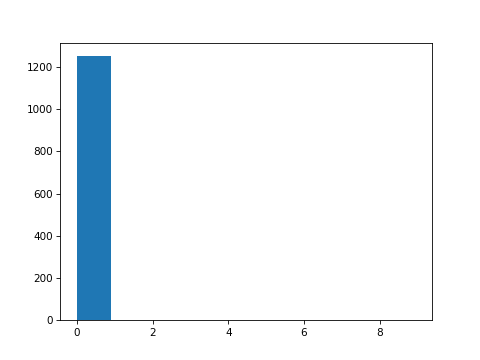

(0.000339, 8.93292)


In [157]:
pl.figure()
pl.hist(o_times/1E6)
print(o_times.min()/1E6, o_times.max()/1E6)

In [80]:
for r, s in zip(trials, ann_starts):
    print(trials['response_time'] - s.time)

TypeError: list indices must be integers, not str

In [69]:
r

{'action': 'draw',
 'duration': 83306,
 'file_hash': '7d2a98d85daef3ca7883542062461e2edd02794f',
 'filename': '/var/folders/nb/yv6_dvnd3zz5ddtkty_drsb00000gn/T/MWorks/Experiment Cache/_Users_labuser_Downloads_RatBehaviorGeneral_Behavior_3Dtransforms_2way_blobs/tmp/Blobs_TrainingRatsD1D2/Blob_N2_CamRot_y0.png',
 'name': 'Blob_N2_CamRot_y0.png 2',
 'pos_x': 0.0,
 'pos_y': 0.0,
 'response': 'unknown',
 'response_time': 'unknown',
 'rotation': 0.0,
 'size_x': 52.40999984741211,
 'size_y': 52.40999984741211,
 'time': 440005781828,
 'type': 'image'}

In [70]:
trials

[]

In [ ]:
vi /n/coxfs01/behavior-data/threeport/cohort_data/AL_Cohort/sorted/rt_perf_scatterplot.py

#### Checking funky files:

In [234]:
fn = '/media/julianarhee/BK/mworks_data/AG/AG2_150803.mwk'
df = pymworks.open(fn)



In [235]:
print "response types:", response_types
print "outcome_types:", outcome_types

response types: ['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
outcome_types: ['success', 'ignore', 'failure']


In [236]:
trials, flags = parse_trials(df, response_types=response_types, ignore_flags=ignore_flags)


['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
['success', 'ignore', 'failure']
N total response events:  0
N total outcome events:  0
Found and removed 0 orphan stimulus events in file /media/julianarhee/BK/mworks_data/AG/AG2_150803.mwk
N valid trials: 0


In [241]:
boundary = get_run_time(df)
(boundary[1] - boundary[0]) /1E6

1.895642

In [243]:
df.get_events('#state_system_mode')

[Event[code=5, name=#state_system_mode, time=422098815072, value=0],
 Event[code=5, name=#state_system_mode, time=422098998966, value=0],
 Event[code=5, name=#state_system_mode, time=422131902902, value=2],
 Event[code=5, name=#state_system_mode, time=422131902909, value=2],
 Event[code=5, name=#state_system_mode, time=422133798544, value=1],
 Event[code=5, name=#state_system_mode, time=422133799168, value=0],
 Event[code=5, name=#state_system_mode, time=422135401853, value=2],
 Event[code=5, name=#state_system_mode, time=422135401859, value=2],
 Event[code=5, name=#state_system_mode, time=428988902033, value=1],
 Event[code=5, name=#state_system_mode, time=428988902618, value=0]]

#### Testing / debugging Session objects:

In [190]:
curr_session = 20150314 #20160623 #session_list[pre_morphs] # 20150211

datestr = session_list[session_list.index(curr_session)]
dfn = [f for f in raw_fns if animalid in f and str(datestr)[2:] in f][0]
print dfn

/n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_150314.mwk


In [153]:
# df = pymworks.open(dfn)
# trials, flags = parse_trials(df)

['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
['success', 'ignore', 'failure']
N total response events:  1051
N total outcome events:  1051
Found and removed 110 orphan stimulus events in file /n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_160623.mwk
N valid trials: 941


In [191]:
S = Session(dfn)
S.parse_trials(response_types=['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore'], \
                 outcome_types = ['success', 'ignore', 'failure'])

['Announce_AcquirePort1', 'Announce_AcquirePort3', 'ignore']
['success', 'ignore', 'failure']
N total response events:  335
N total outcome events:  335
Found and removed 57 orphan stimulus events in file /n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_150314.mwk
N valid trials: 278


In [192]:
S.get_counts_by_stimulus()

In [193]:
# Check if there are morphs also:
morph_list = [s for s in S.stats.keys() if 'morph' in s]
if len(morph_list) > 0:
    stimulus_list = [s for s in S.stats.keys() if s not in morph_list]
else:
    stimulus_list = S.stats.keys()
print stimulus_list

['Blob_N2_CamRot_y0', 'Blob_N1_CamRot_y0']


In [194]:


values = [('%s_%s' % (stim.split('_')[1], stim.split('_')[3]), \
                       S.stats[stim]['nsuccess']/float(S.stats[stim]['ntrials'])) for stim in stimulus_list]

In [195]:
values

[('N2_y0', 0.9496402877697842), ('N1_y0', 0.9136690647482014)]

In [142]:
#stimulus_list = S.stimuli
stimulus_list = [s for s in S.stats.keys() if 'morph' in s]

print stimulus_list

['morph0', 'morph1', 'morph3', 'morph5', 'morph6', 'morph7', 'morph8', 'morph9', 'morph12', 'morph13', 'morph10', 'morph11', 'morph16', 'morph14', 'morph15', 'morph2', 'morph4']


In [147]:
values = [('morph_%s' % (stim.split('morph')[1]), \
                       S.stats[stim]['nchoose1']/float(S.stats[stim]['ntrials'])) for stim in stimulus_list]

In [148]:
values

[('morph_0', 0.0),
 ('morph_1', 0.0),
 ('morph_3', 0.0),
 ('morph_5', 0.0),
 ('morph_6', 0.0),
 ('morph_7', 0.0),
 ('morph_8', 0.14285714285714285),
 ('morph_9', 0.14285714285714285),
 ('morph_12', 0.5714285714285714),
 ('morph_13', 0.875),
 ('morph_10', 0.375),
 ('morph_11', 0.5),
 ('morph_16', 1.0),
 ('morph_14', 0.625),
 ('morph_15', 0.7142857142857143),
 ('morph_2', 0.0),
 ('morph_4', 0.14285714285714285)]

#### Compare session numbers

In [15]:
dates = np.arange(all_sessions[0], all_sessions[-1])
print dates[0:10]

[20150202 20150203 20150204 20150205 20150206 20150207 20150208 20150209
 20150210 20150211]


In [ ]:
color_list = ['r', 'g', 'b']
pl.figure(figsize=(20,5))
for ai, animal in enumerate(sessions.keys()):
    session_list = sessions[animalid]
    pl.scatter([i for i in np.arange(len(dates))], [1+ai if dt in session_list else 0 for dt in dates], color=color_list[ai])
    

In [17]:
datestr = session_list[-10]
dfn = [f for f in raw_fns if animalid in f and str(datestr)[2:] in f] # saved datestr is YYMMDD.mwk
print dfn
dfn = dfn[0]
df = pymworks.open(dfn)

['/n/coxfs01/behavior-data/threeport_morphs/AG/raw/AG2_161130.mwk']


In [ ]:
codec = df.get_codec()

In [ ]:
trial[stm_property] = events[index - 1].value

In [46]:

trials = []
trial_num = 1
for index, event in enumerate(events):
    if (event.name == "Announce_TrialStart" and
    event.value == 1):
        trial = {
            'trial_num': trial_num,
            'stim_presentation_time': None,
            'behavior_outcome_time': None,
            'time_for_relay_on': None,
            'reaction_time': None,
            'behavior_outcome': None,
            'BlobIdentityIdx': None,
            'stm_size': None,
            'stm_pos_x': None,
            'stm_pos_y': None,
            'stm_rotation': None,
            'stm_rotation_in_depth': None,
            #'stm_rotation_in_depth_x_axis': None,
            'DepthRotation_X_Axis': None,
            'stm_lighting': None
        }

        #COLLECT STIMULUS PROPERTIES FOR THIS TRIAL
        stm_properties = [
            'BlobIdentityIdx',
            'stm_size',
            'stm_pos_x',
            'stm_pos_y',
            'stm_rotation',
            'stm_rotation_in_depth',
            #'stm_rotation_in_depth_x_axis',
            'DepthRotation_X_Axis',
            'stm_lighting']
        for stm_property in stm_properties:
            try:
                if events[index - 1].name == stm_property:
                    trial[stm_property] = events[index - 1].value
                elif events[index - 2].name == stm_property:
                    trial[stm_property] = events[index - 2].value
                elif events[index - 3].name == stm_property:
                    trial[stm_property] = events[index - 3].value
                elif events[index - 4].name == stm_property:
                    trial[stm_property] = events[index - 4].value
                elif events[index - 5].name == stm_property:
                    trial[stm_property] = events[index - 5].value
                elif events[index - 6].name == stm_property:
                    trial[stm_property] = events[index - 6].value
                elif events[index - 7].name == stm_property:
                    trial[stm_property] = events[index - 7].value
                elif events[index - 8].name == stm_property:
                    trial[stm_property] = events[index - 8].value
            except IndexError:
                print stm_property + ' out of range for session', session_filepath, index

        #COLLECT BEHAVIORAL OUTCOME FOR THIS TRIAL AND ITS TIME
        #subtract start_time for all times in order to get all time relative to start_time
        try:
            if events[index + 1].name == '#stimDisplayUpdate':
                trial['stim_presentation_time'] = events[index + 1].time - start_time
        except IndexError:
            print 'stim_presentation_time out of range for session', session_filepath, index
        try:
            if events[index + 2].name in ['Announce_AcquirePort1', 'Announce_AcquirePort3']:
                trial['behavior_outcome_time'] = events[index + 2].time - start_time
        except IndexError:
            print 'behavior_outcome_time out of range for session', session_filepath, index
        try:
            if events[index + 3].name in ['success', 'failure', 'ignore']:
                trial['behavior_outcome'] = events[index + 3].name
        except IndexError:
            print 'behavior_outcome out of range for session', session_filepath, index

        if trial['behavior_outcome_time'] is not None and trial['stim_presentation_time'] is not None:
            trial['reaction_time'] = (trial['behavior_outcome_time'] - trial['stim_presentation_time'])*.001

        #print trial

        #CHECK OUTCOME AND ESSENTIAL STM PROPERTIES HAVE BEEN COLLECTED FOR THIS TRIAL
        #(not including all stm properties so the code is flexible for simpler protocols)
        if (
        trial['behavior_outcome'] is not None and
        trial['stim_presentation_time'] is not None and
        trial['behavior_outcome_time'] is not None and
        #trial['BlobIdentityIdx'] is not None and
        #trial['stm_size'] is not None and
        trial['stm_rotation_in_depth'] is not None):
            trials.append(trial)
            trial_num += 1

print 'number of trials:', len(trials)

number of trials: 0


In [ ]:
codec

In [ ]:
df.get_events('TooFast_time')

In [ ]:
tstarts = [t for t in df.get_events('Announce_TrialStart') if t.value==1]
tends = [t for t in df.get_events('Announce_TrialEnd') if t.value==1]
print len(tstarts)
print len(tends)

In [ ]:
446+447+37

In [42]:
events = df.get_events([
    'Announce_TrialStart',#when value = 1, used for identifying real trials (some information will be before and some after this variable)
    'Announce_TrialEnd',#when value = 1, used for identifying the end of real trials
    '#stimDisplayUpdate',#time display is updated with stimulus, blank screen, etc on screen
    'Announce_AcquirePort1',#time when first lick is registered as response
    'LickInput2', #center port response
    'Announce_AcquirePort3',#time when first lick is registered as response
    'success',#behavioral outcome
    'failure',#behavioral outcome
    'ignore',#behavioral outcome
    'stm_size',#size of stimulus in degrees of visual angle
    'stm_rotation',#planar rotation
    'stm_rotation_in_depth',#depth rotation
    #'stm_rotation_in_depth_x_axis', #elevation, or depth rotation in x axis
    #'DepthRotation_X_Axis', #elevation, or depth rotation in axis (0 = 1, 1 = -10, 2 = 10 for stm_rotation_depth_in_x_axis)
    #'stm_lighting',#lighting on stimulus
    'stm_pos_x',#stimulus position in x (horizontal)
    'stm_pos_y',#stimulus position in y (vertical)
    'BlobIdentityIdx'#index assigned to blob 1 or 2 to identify them
    ]
)

In [ ]:
        trial = {
            'trial_num': trial_num,
            'stim_presentation_time': None,
            'behavior_outcome_time': None,
            'time_for_relay_on': None,
            'reaction_time': None,
            'behavior_outcome': None,
            'BlobIdentityIdx': None,
            'stm_size': None,
            'stm_pos_x': None,
            'stm_pos_y': None,
            'stm_rotation': None,
            'stm_rotation_in_depth': None,
            #'stm_rotation_in_depth_x_axis': None,
            'DepthRotation_X_Axis': None,
            'stm_lighting': None
        }

In [44]:
#specifically like this:
#Event[code=6, name=#announceMessage, time=73268313109, value={'origin': 1, 'domain': 0, 'type': 0, 'message': 'Setting protocol to Test all transformations'}]
#there are three other #announceMessage events before the relevant one, so it's the fourth one, hence index = 3
announceMessage = df.get_events(['#announceMessage'])
start_time = announceMessage[3].time
ann_starts = sorted([ev for ev in events if ev.name=='Announce_TrialStart' and ev.value==1], key=lambda e: e.time)


In [45]:
announceMessage

[Event[code=6, name=#announceMessage, time=438741934550, value=0],
 Event[code=6, name=#announceMessage, time=438741934950, value={'origin': 1, 'domain': 8, 'type': 0, 'message': 'Opening data file: /Users/labuser/Documents/MWorks/Data/AL13_170912.mwk'}],
 Event[code=6, name=#announceMessage, time=438742197537, value=0],
 Event[code=6, name=#announceMessage, time=439833697648, value={'origin': 1, 'domain': 0, 'type': 0, 'message': 'Setting protocol to Staircase through shape parameters'}],
 Event[code=6, name=#announceMessage, time=439833697709, value={'origin': 1, 'domain': 0, 'type': 0, 'message': 'Called start on state system'}],
 Event[code=6, name=#announceMessage, time=439833697827, value={'origin': 1, 'domain': 0, 'type': 0, 'message': 'Starting state system....'}],
 Event[code=6, name=#announceMessage, time=439833707846, value={'origin': 1, 'domain': 6, 'type': 0, 'message': 'Display updates started (main = 188789496, current = 188789496)'}],
 Event[code=6, name=#announceMessag

In [51]:
ann_starts = sorted([ev for ev in events if ev.name=='Announce_TrialStart' and ev.value==1], key=lambda e: e.time)

len(ann_starts)

454

In [52]:
currt = ann_starts[0]
currt

Event[code=80, name=Announce_TrialStart, time=439856778396, value=1]

In [57]:
ann_starts[-1].time - ann_starts[0].time


4927178532